In [1]:
!nvidia-smi

Sat May 15 01:51:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:AF:00.0 Off |                    0 |
| N/A   31C    P0    25W / 250W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import numpy as np
import h5py
import unet_uae_filter_16_32_32_64 as vae_util
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf 
# tf.config.gpu.set_per_process_memory_fraction(0.75)
# tf.config.gpu.set_per_process_memory_growth(True)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
K.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [3]:
def load_data(data_path, array_name_list):
    hf_r = h5py.File(data_path, 'r')
    result = []
    for name in array_name_list:
        result.append(np.array(hf_r.get(name)))
    hf_r.close()
    return result

In [4]:
data_dir = './data'
# load training data
data_path = os.path.join(data_dir, '2998reals_ccs_data_xyz_20_20_5')
sat_t, logk, p_t, ground_disp_t = load_data(data_path, ['sat', 'logk', 'p', 'ground_disp'])
# sat_t = np.delete(sat_t, 1251, axis = 0) # index 1251 should be removed as an outlier
# logk = np.delete(logk, 1251, axis = 0)
# load eval data
print('sw_t shape is ', sat_t.shape)
print('logk shape is ', logk.shape)
print('p_t shape is ', p_t.shape)
print('ground_disp shape is ', ground_disp_t.shape)

sw_t shape is  (2998, 11, 12, 40, 40)
logk shape is  (2998, 12, 40, 40)
p_t shape is  (2998, 11, 12, 40, 40)
ground_disp shape is  (2998, 11, 41, 41)


In [5]:
ground_disp_t_processed = ground_disp_t[:, :, 1:, :] + ground_disp_t[:, :, :-1, :]
ground_disp_t_processed = (ground_disp_t_processed[:, :, :, 1:] + ground_disp_t_processed[:, :, :, :-1])/4

In [6]:
ground_disp_t_processed = np.repeat(ground_disp_t_processed[:, :, np.newaxis, :, :], 12, axis = 2)

In [7]:
ground_disp_t = ground_disp_t_processed

In [8]:
depth = 10
nr = logk.shape[0]
train_nr = 2000
test_nr = 500

In [9]:
ground_disp_t_mean = np.mean(ground_disp_t[:train_nr, ...], axis = 0, keepdims = True)
ground_disp_t_std = np.std(ground_disp_t[:train_nr, ...], axis = 0, keepdims = True)
ground_disp_t = ground_disp_t - ground_disp_t_mean
print('max ground_disp is ', np.max(ground_disp_t[:train_nr, ...]), ', min ground_disp is ', np.min(ground_disp_t[:train_nr, ...]))
max_ground_disp = np.max(ground_disp_t[:train_nr, ...], axis=(0,1,2,3), keepdims = True)
min_ground_disp = np.min(ground_disp_t[:train_nr, ...], axis=(0,1,2,3), keepdims = True)

max ground_disp is  0.07397514215000012 , min ground_disp is  -0.04850251290000002


In [10]:
ground_disp_t.max()

0.07397514215000012

In [11]:
ground_disp_t = ground_disp_t / (ground_disp_t_std + 1e-6)

In [12]:
print('max disp is ', np.max(ground_disp_t), ', min disp is ', np.min(ground_disp_t))
print('max disp train is ', np.max(ground_disp_t[:train_nr, ...]), ', min disp train is ', np.min(ground_disp_t[:train_nr, ...]))
print('max disp validation is ', np.max(ground_disp_t[test_nr:, ...]), ', min disp validation is ', np.min(ground_disp_t[test_nr:, ...]))

max disp is  7.154548930340586 , min disp is  -4.385237086089987
max disp train is  7.154548930340586 , min disp train is  -4.137416121884065
max disp validation is  7.154548930340586 , min disp validation is  -4.385237086089987


In [13]:
#step_index = [1, 2, 3, 6, 8, 10, 12, 14, 17, 20]
step_index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_x = logk[:train_nr, ...]
train_y = ground_disp_t[:train_nr, step_index, :,  :, :]

test_x = logk[nr-test_nr:, ...]
test_y = ground_disp_t[nr-test_nr:, step_index, :,  :, :]

train_x = train_x[:, :, :, :, None]
train_y = train_y[:, :, :, :, :, None]
test_x = test_x[:, :, :, :, None]
test_y = test_y[:, :, :, :, :, None]
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)

train_x shape is  (2000, 12, 40, 40, 1)
train_y shape is  (2000, 10, 12, 40, 40, 1)
test_x shape is  (500, 12, 40, 40, 1)
test_y shape is  (500, 10, 12, 40, 40, 1)


<Figure size 432x288 with 0 Axes>

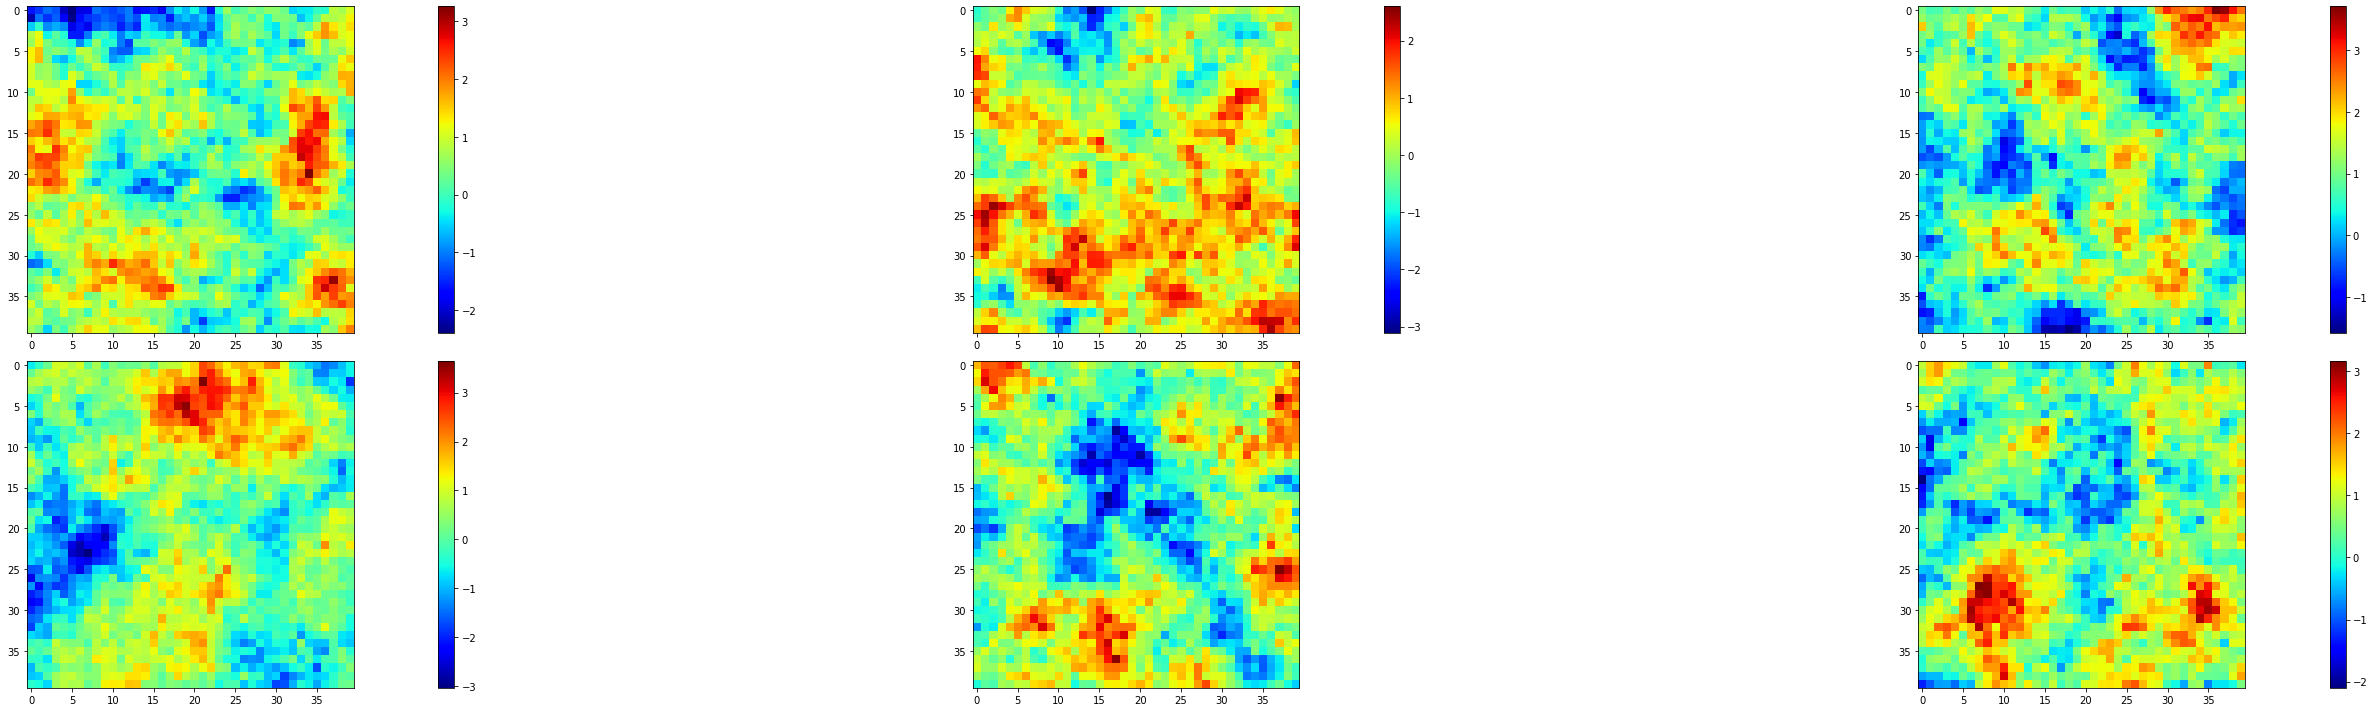

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')
ind_case = [0, 10, 20, 30, 40, 50]
plt.figure(figsize=(50,10))
for i, k in enumerate(ind_case):
    plt.subplot(2, 3, i+1)
    plt.imshow(train_x[k, 0, :, :, 0])
    plt.colorbar(fraction=0.046)
    plt.tight_layout()
plt.show()

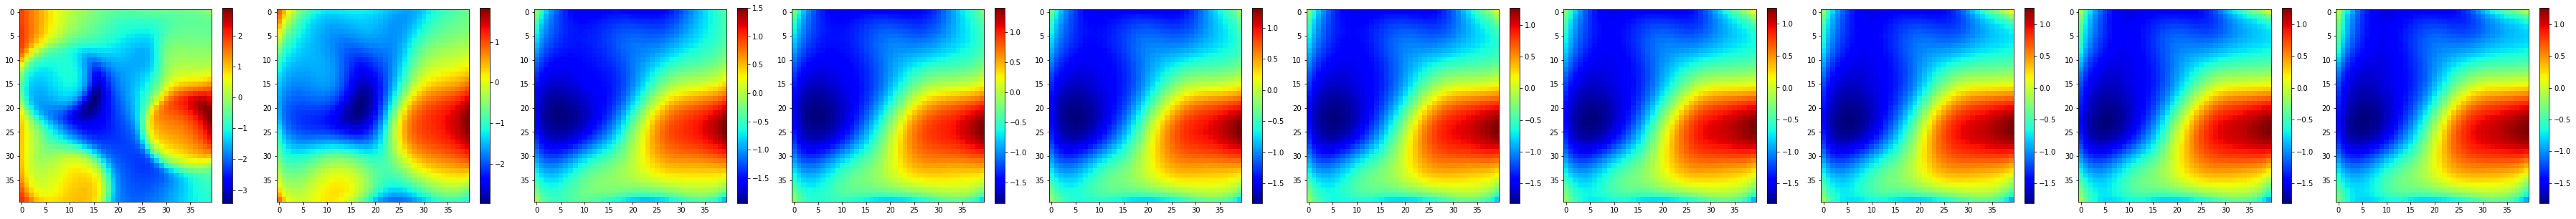

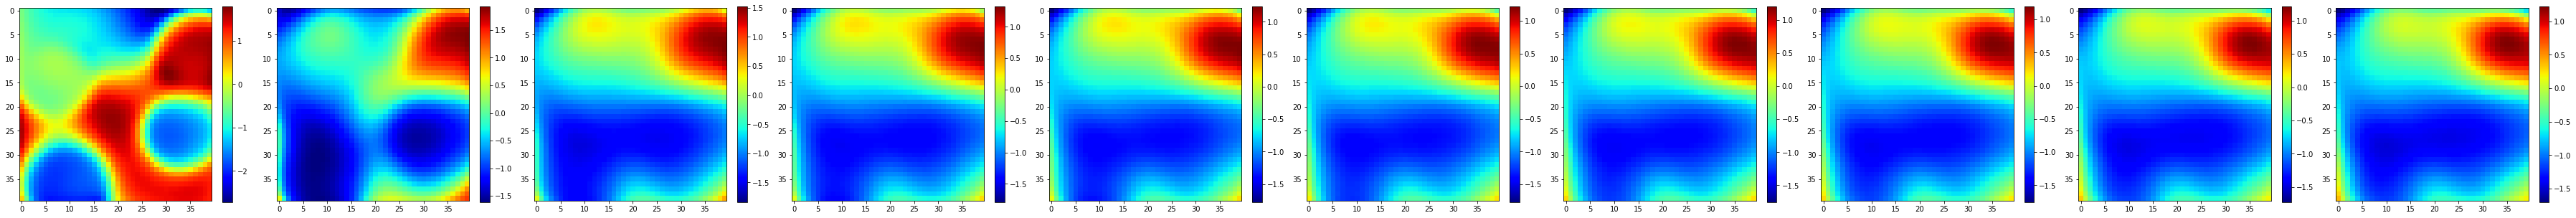

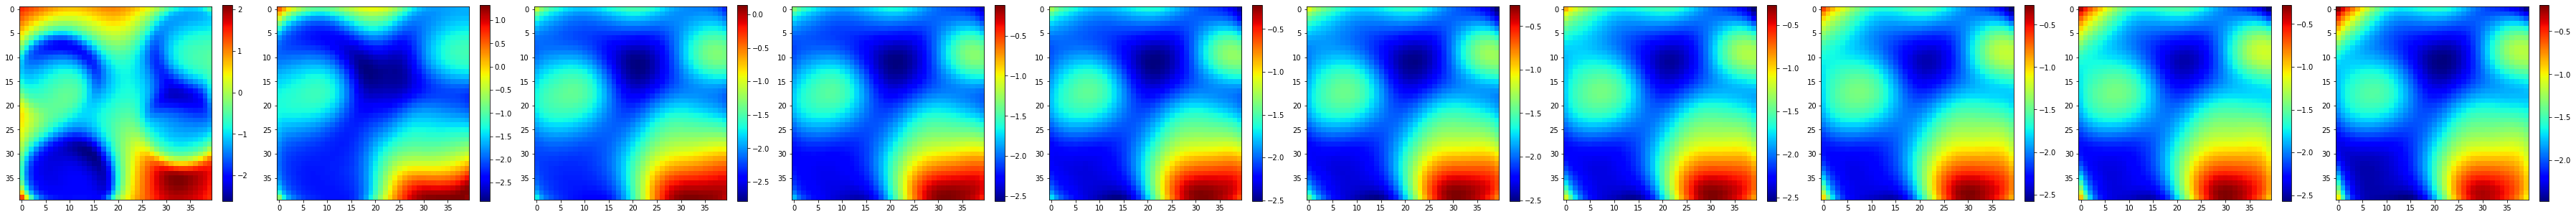

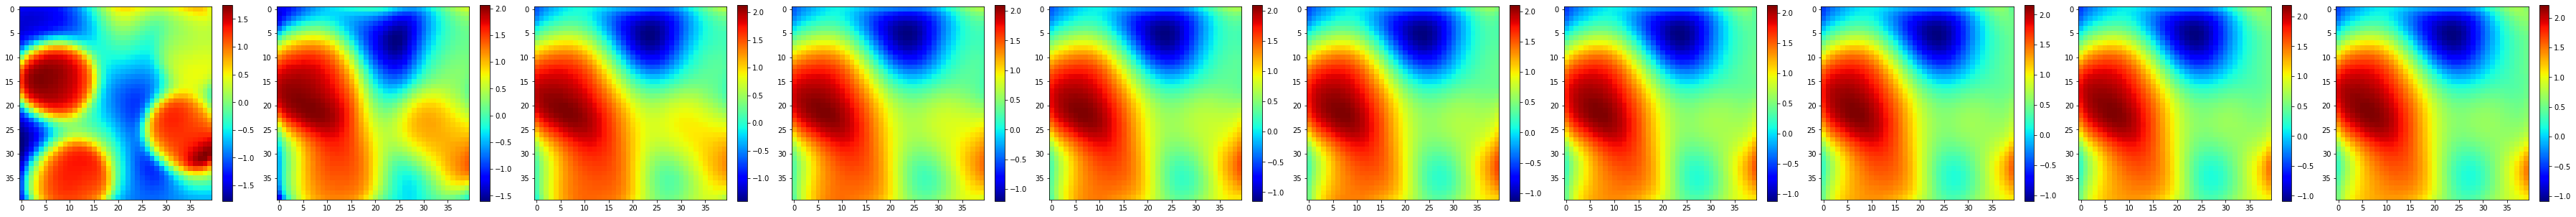

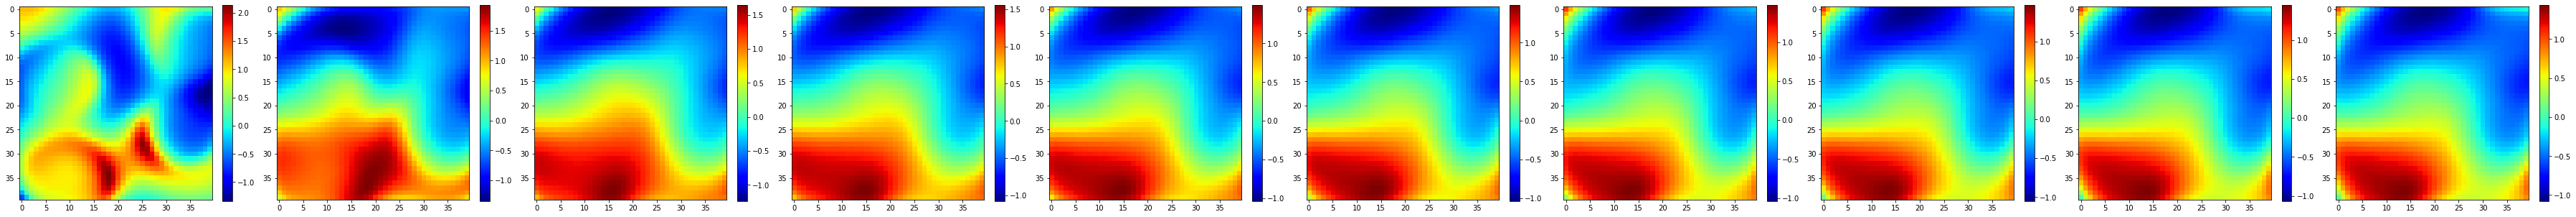

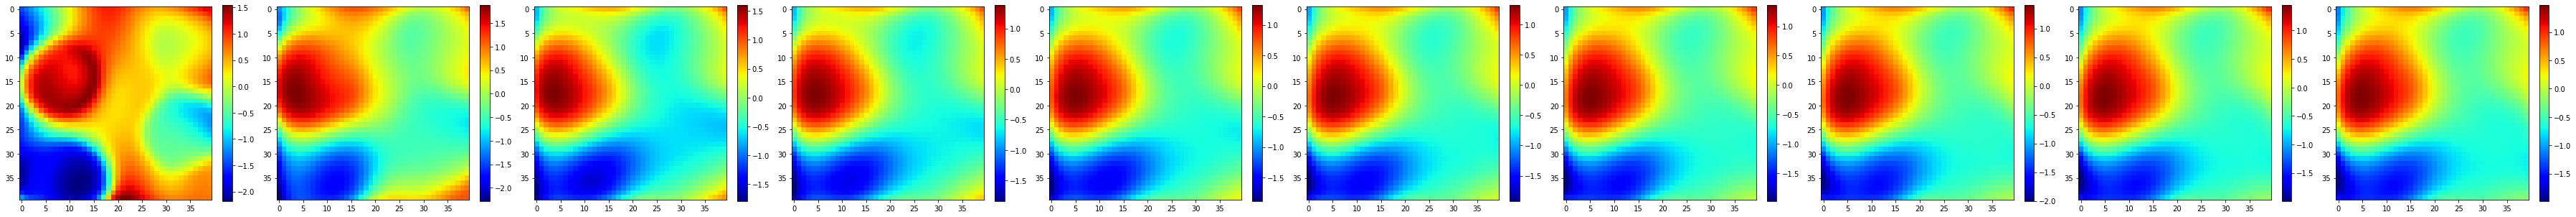

In [15]:
for i, k in enumerate(ind_case):
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(1, depth, i_tstep+1)
        plt.imshow(train_y[k, i_tstep, 0,  :, :, 0])
        plt.colorbar(fraction=0.046)
        plt.tight_layout()
plt.show()

In [16]:
input_shape=(12, 40, 40, 1)
vae_model,_ = vae_util.create_vae(input_shape, depth)
vae_model.summary(line_length=150)





______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
image (InputLayer)                               (None, 12, 40, 40, 1)            0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d_1 (Conv3D)                                (None, 6, 20, 20, 16)            448               image[0][0]                                       
______________________________________________________________________________________________________________________________________________________
batch_normalization_1 (BatchNormalization)       (None, 6, 20, 20, 16)            64      

In [17]:
output_dir = 'saved_models/'
vae_model.load_weights(output_dir + 'saved-model-10steps-lr3e-4-displacmeent-detrend-hd-0-filter_16_32_32_64-mse-300-6318.74.h5')

In [18]:
pred_list = []
test_batch_size = 10 
batch_num = int(test_nr / test_batch_size) + 1
for i in range(batch_num):
    next_batch_idx = min((i+1)*test_batch_size, test_x.shape[0])
    pred_list.append(vae_model.predict(test_x[i*test_batch_size: next_batch_idx, ...]))

pred = np.concatenate(pred_list[:-1], axis = 0)
print(pred.shape)

(500, 10, 12, 40, 40, 1)


In [19]:
pred.shape

(500, 10, 12, 40, 40, 1)

In [20]:
d_pred = pred[:, :, :, :, :, 0]
d_true = test_y[:, :, :, :, :, 0]

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')

<Figure size 432x288 with 0 Axes>

In [22]:
d_pred.shape

(500, 10, 12, 40, 40)

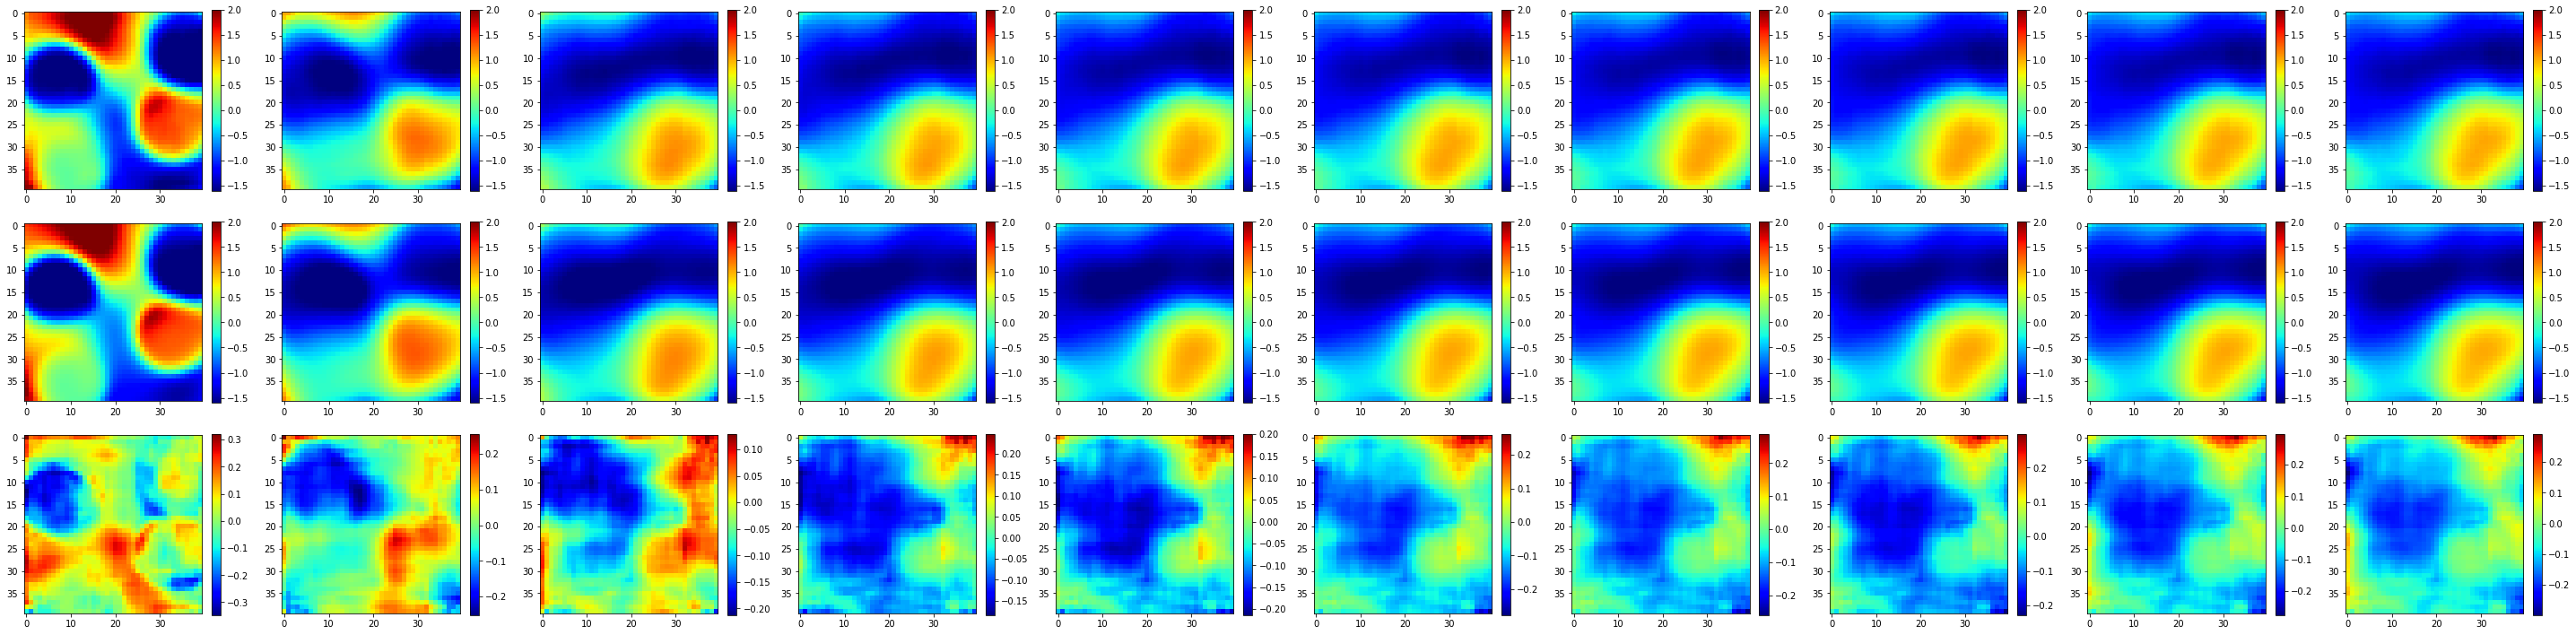

In [23]:
ind_case = [200]
ind_z = 0
for k in ind_case:
    plt.figure(figsize=(40,10))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(d_pred[k, i_tstep, 0, :, :], vmin = -1.6, vmax = 2.0)
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(d_true[k, i_tstep, 0, :, :], vmin = -1.6, vmax = 2.0)
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(d_true[k, i_tstep, 0, :, :] - d_pred[k, i_tstep, 0, :, :])

        plt.colorbar(fraction=0.046)
        #plt.clim([-0.2, 0.2])
        plt.tight_layout()
plt.show()

In [24]:
ground_disp_t_std.shape

(1, 11, 12, 40, 40)

In [25]:
ground_disp_t_mean.shape

(1, 11, 12, 40, 40)

In [26]:
ground_disp_t_std.shape

(1, 11, 12, 40, 40)

In [27]:
d_true = (ground_disp_t_std[:, 1:, :, :, :] + 1e-6) * (d_true) + ground_disp_t_mean[:, 1:, :, :, :] 
d_pred = (ground_disp_t_std[:, 1:, :, :, :] + 1e-6) * (d_pred) + ground_disp_t_mean[:, 1:, :, :, :] 

In [28]:
d_true.shape

(500, 10, 12, 40, 40)

In [29]:


def plot_model(m, nx=40, ny=40, inj_x=None, inj_y=None, prod_x=None, prod_y=None, ms=20, colorbar=False, clim=None, mc='w'):
    im = plt.imshow(m)
    if colorbar:
        plt.colorbar(fraction=0.046, pad=0.04)
    if clim:
        plt.clim(clim)
    plt.scatter(inj_x, inj_y, marker='v', s=ms, c=mc)
    plt.scatter(prod_x, prod_y, marker='o', s=ms, c=mc)
    
    # add text
    for i in range(inj_x.shape[0]):
        plt.text(inj_x[i]-2, inj_y[i] - 6, s = 'I'+str(i+1), fontsize=12, color = 'w', weight='heavy')
    
    for i in range(prod_x.shape[0]):
        plt.text(prod_x[i]-3, prod_y[i] - 6 , s = 'P'+str(i+1), fontsize=12, color = 'w', weight='heavy')
    
    plt.gca().invert_yaxis()
    return im



def plot_model_40x40_4w(m, ms=50, colorbar=False, mc='w', clim=None):
    
    obs_loc_x = [9, 10, 35, 31, 20]
    obs_loc_y = [7, 30, 15, 32, 20]
    prod_x = None
    prod_y = None
    inj_x = obs_loc_x[:1]
    inj_y = obs_loc_y[:1]
    im = plot_model(m, nx=40, ny=40, inj_x=inj_x, inj_y=inj_y, prod_x=prod_x, prod_y=prod_y, ms=ms, colorbar=colorbar, mc=mc, clim=clim)
    
    return im

In [30]:

obs_loc_x = [9, 10, 35, 31, 20]
obs_loc_y = [7, 30, 15, 32, 20]

In [31]:
d_pred.max()

0.1789659067602815

[8, 10, 35, 32]


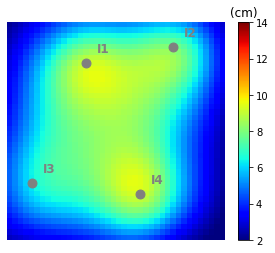

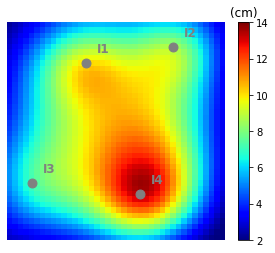

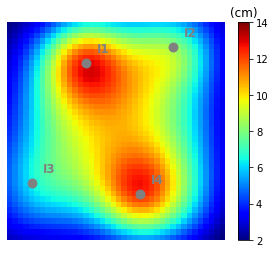

In [32]:
ind_case = [272, 223, 365]
obs_loc_x = [9, 10, 35, 31, 20]
obs_loc_y = [7, 30, 15, 32, 20]
well_loc_x = [8, 10, 35, 32]
well_loc_y = [15, 35,9, 25]
prod_x = None
prod_y = None
inj_x = well_loc_x
inj_y = well_loc_y
#inj_x = [40 - 1 - x for x in inj_x]
inj_y = [40  - 1 -  y for y in inj_y]
#, inj_y = inj_y, inj_x
print(inj_x)
for k in ind_case:
    plt.figure()
    plt.scatter(inj_y, inj_x, marker='o', s=80, c='gray')
    for i in range(len(inj_x)):
        plt.text(inj_y[i] + 2, inj_x[i] + 2, s = 'I'+str(4-i), fontsize=12, color = 'gray', weight='heavy')
        
    im = plt.imshow(d_true[k, -1, 0, ::-1, :].transpose() * 100, vmin = 2, vmax = 14)
    
#     plt.scatter(inj_y, inj_x, marker='v', s=80, c='gray')
#     for i in range(len(inj_x)):
#         plt.text(inj_y[i]-2, inj_x[i] - 2, s = 'I'+str(i+1), fontsize=12, color = 'gray', weight='heavy')
        
    plt.gca().invert_yaxis()
    plt.axis('off')
    clb = plt.colorbar(fraction = 0.046, pad = 0.04)
    clb.ax.set_title('(cm)')
    im.set_clim([2, 14])

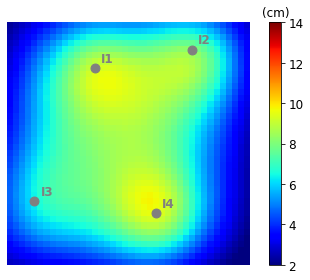

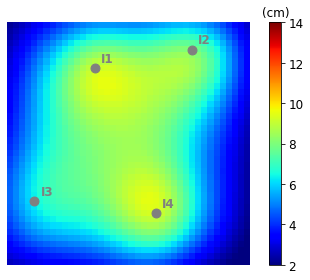

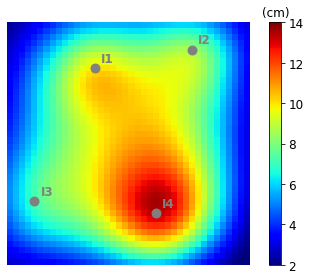

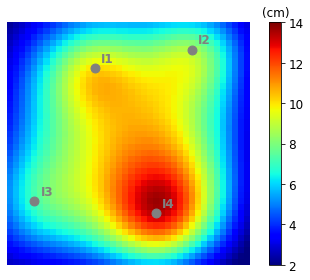

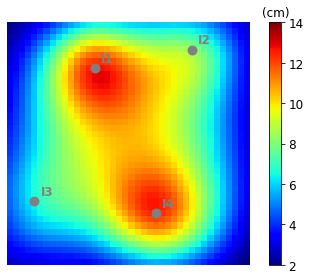

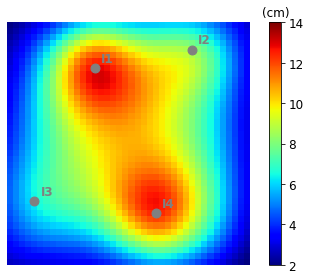

In [33]:

ind_case = [272, 223, 365]
ind_z = 0
for k in ind_case:
    for i_tstep in [9]:
        plt.figure()
        plt.scatter(inj_y, inj_x, marker='o', s=80, c='gray')
        for i in range(len(inj_x)):
            plt.text(inj_y[i] + 1, inj_x[i] + 1, s = 'I'+str(4-i), fontsize=12, color = 'gray', weight='heavy')
        plt.imshow(d_pred[k, i_tstep, 0, ::-1, :].transpose() * 100, vmin = 2, vmax = 14)
        plt.gca().invert_yaxis()

        clb = plt.colorbar(fraction = 0.046)
        clb.ax.set_title('(cm)')
        clb.ax.tick_params(labelsize=12)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('./saved_field_plots/disp_pred_case_{}.png'.format(k))
        plt.figure()
        plt.scatter(inj_y, inj_x, marker='o', s=80, c='gray')
        for i in range(len(inj_x)):
            plt.text(inj_y[i] + 1, inj_x[i] + 1, s = 'I'+str(4-i), fontsize=12, color = 'gray', weight='heavy')
        im = plt.imshow(d_true[k, i_tstep, 0, ::-1, :].transpose() * 100, vmin = 2, vmax = 14)
        
        plt.gca().invert_yaxis()
        clb = plt.colorbar(fraction = 0.046)
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('(cm)')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('./saved_field_plots/disp_true_case_{}.png'.format(k))
plt.show()

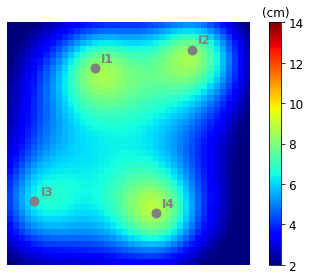

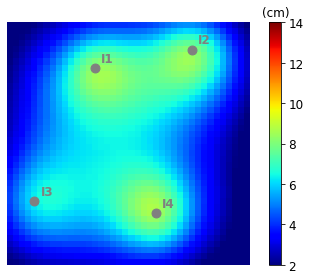

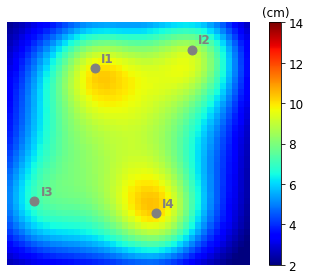

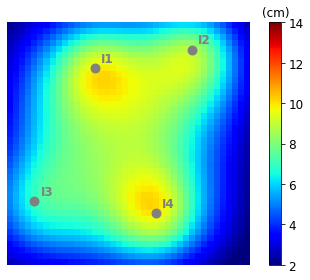

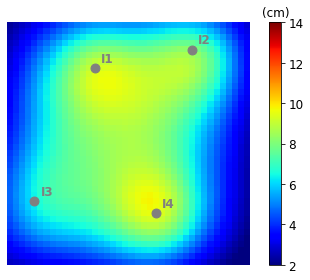

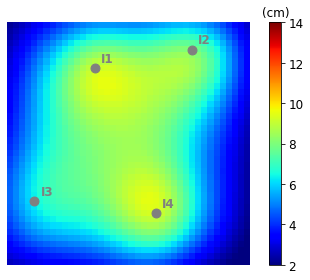

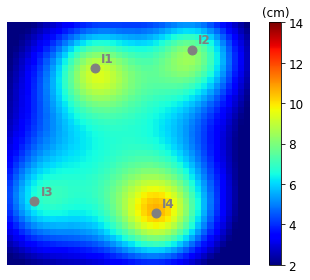

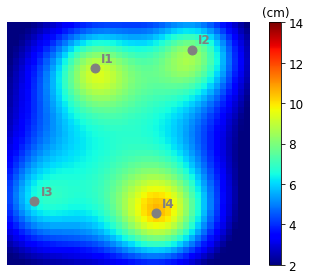

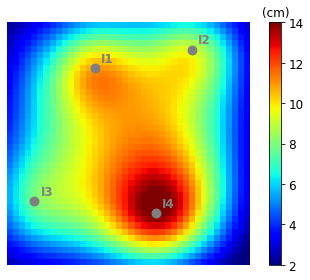

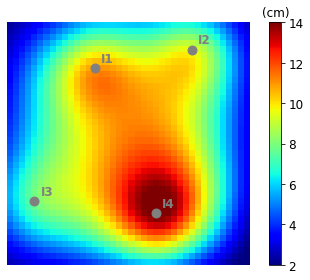

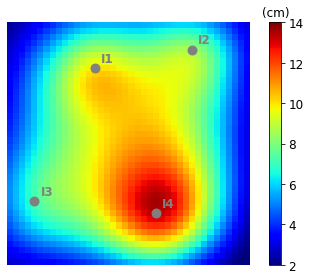

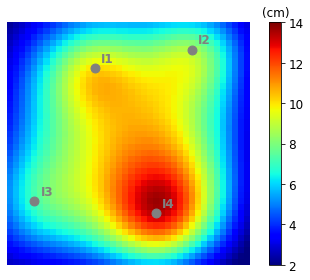

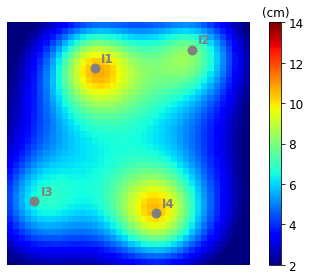

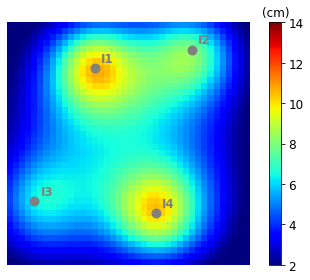

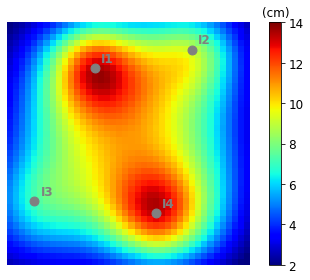

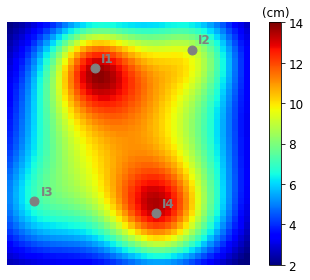

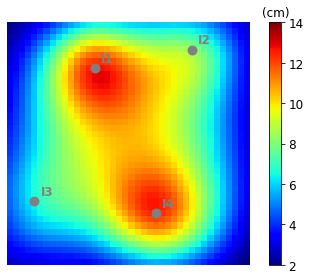

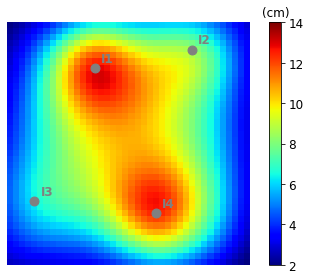

In [34]:
### ind_case = [223]
ind_z = 0
for k in ind_case:
    for i_tstep in [1, 5, 9]:
        plt.figure()
        plt.scatter(inj_y, inj_x, marker='o', s=80, c='gray')
        for i in range(len(inj_x)):
            plt.text(inj_y[i] + 1, inj_x[i] + 1, s = 'I'+str(4-i), fontsize=12, color = 'gray', weight='heavy')
        plt.imshow(d_pred[k, i_tstep, 0, ::-1, :].transpose()* 100, vmin = 2, vmax = 14)
        plt.gca().invert_yaxis()
        clb = plt.colorbar(fraction = 0.046)
        clb.ax.set_title('(cm)')
        clb.ax.tick_params(labelsize=12)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('./saved_field_plots/disp_pred_case_{}_tstep_{}.png'.format(k, i_tstep))
        plt.figure()
        plt.scatter(inj_y, inj_x, marker='o', s=80, c='gray')
        for i in range(len(inj_x)):
            plt.text(inj_y[i] + 1, inj_x[i] + 1, s = 'I'+str(4-i), fontsize=12, color = 'gray', weight='heavy')
        plt.imshow(d_true[k, i_tstep, 0, ::-1, :].transpose() * 100, vmin = 2, vmax = 14)
        plt.gca().invert_yaxis()
        clb = plt.colorbar(fraction = 0.046)
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('(cm)')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('./saved_field_plots/disp_true_case_{}_tstep_{}.png'.format(k, i_tstep))
plt.show()

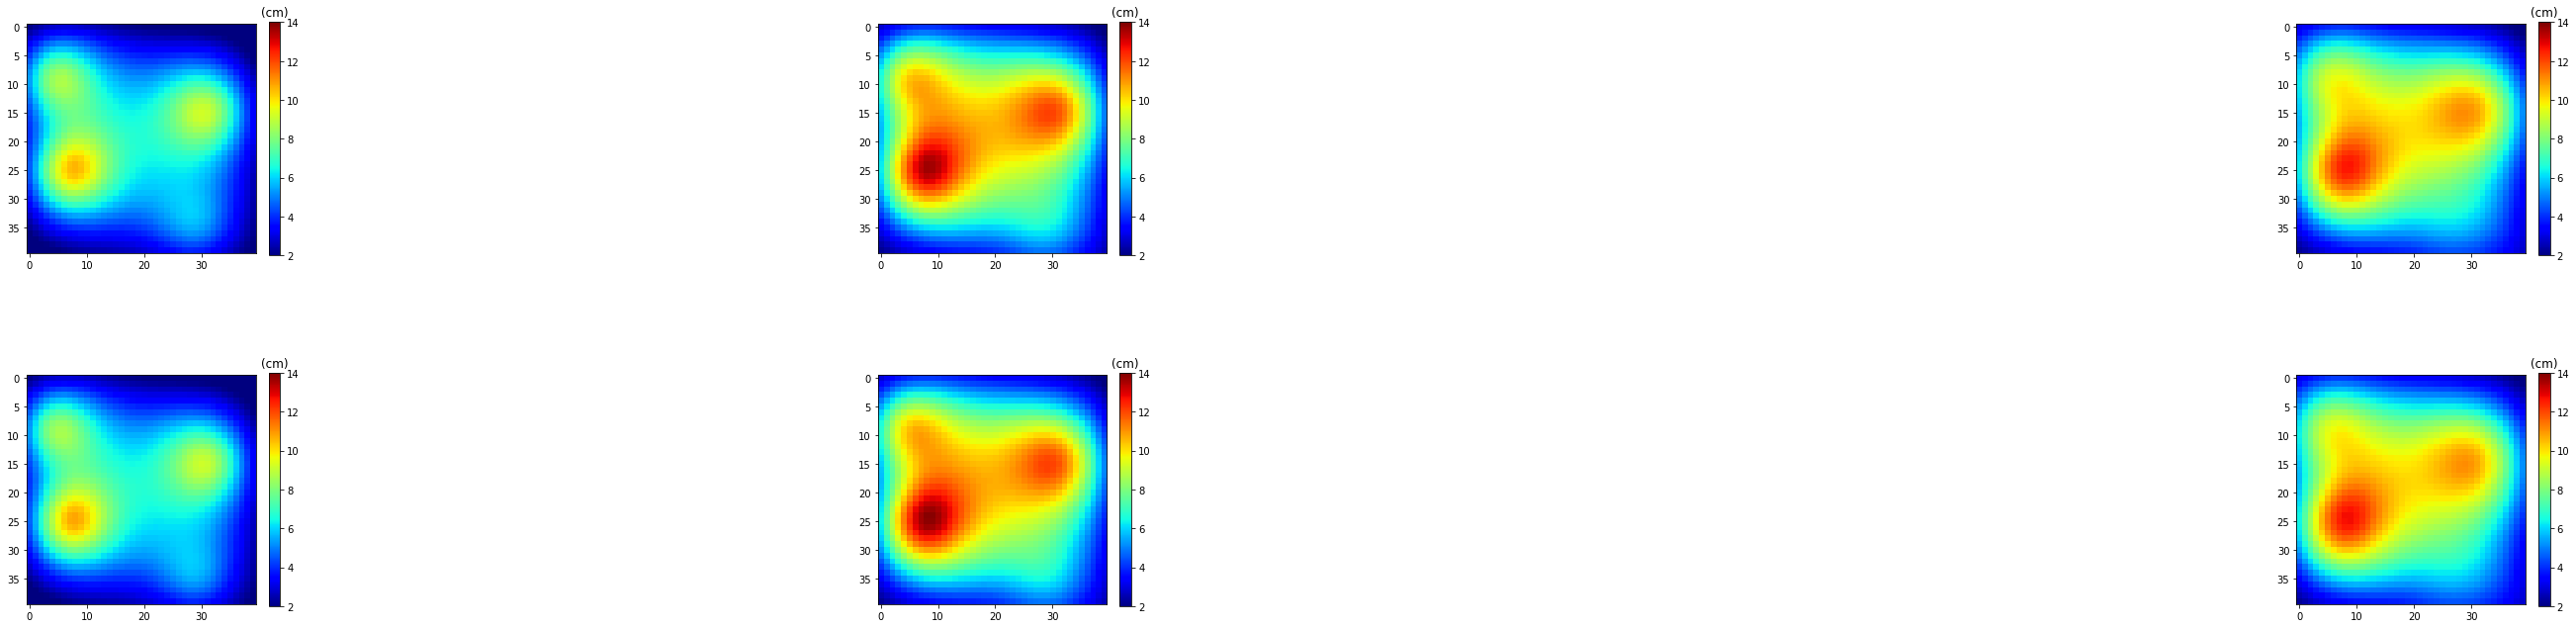

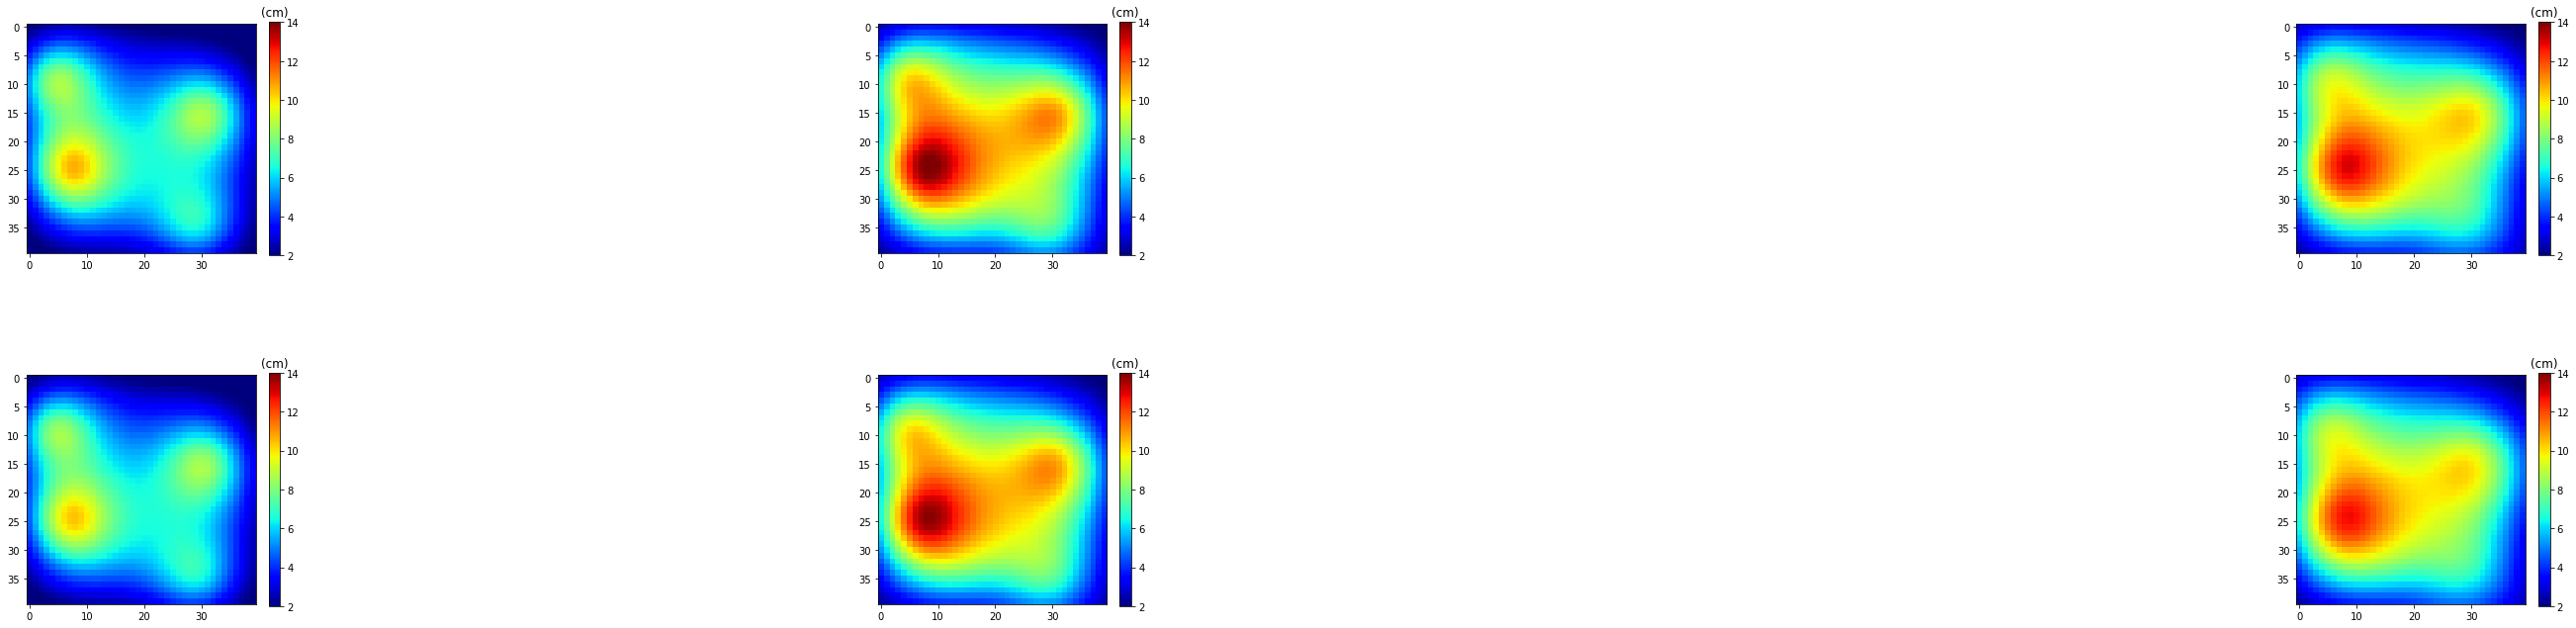

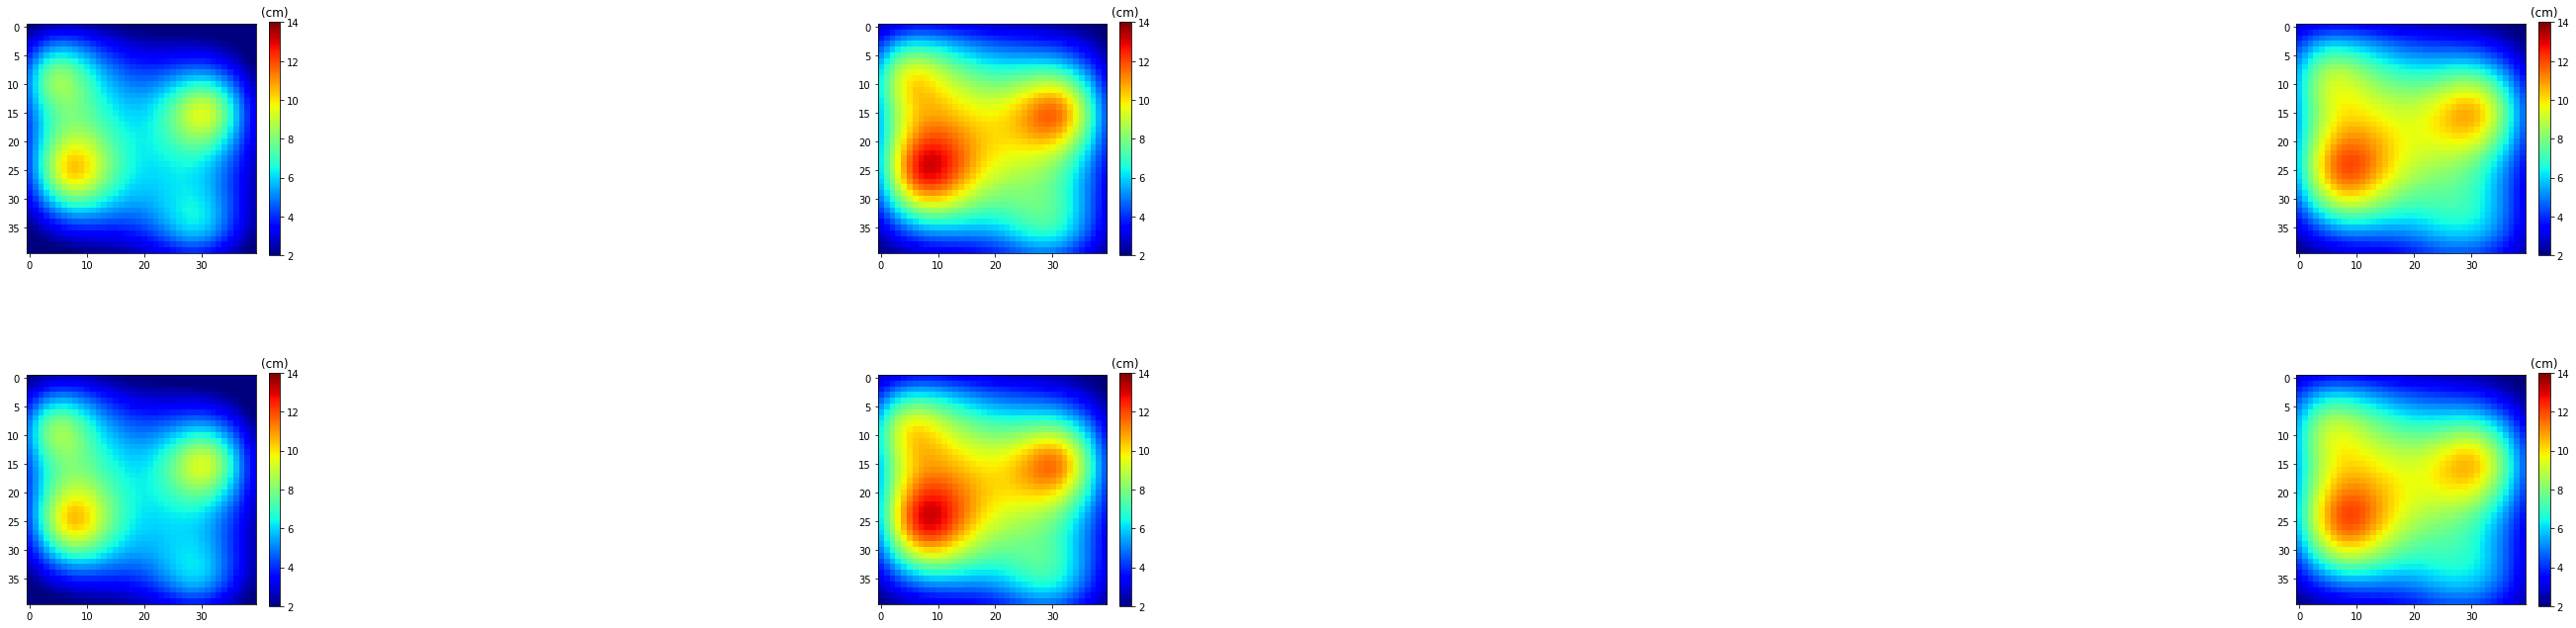

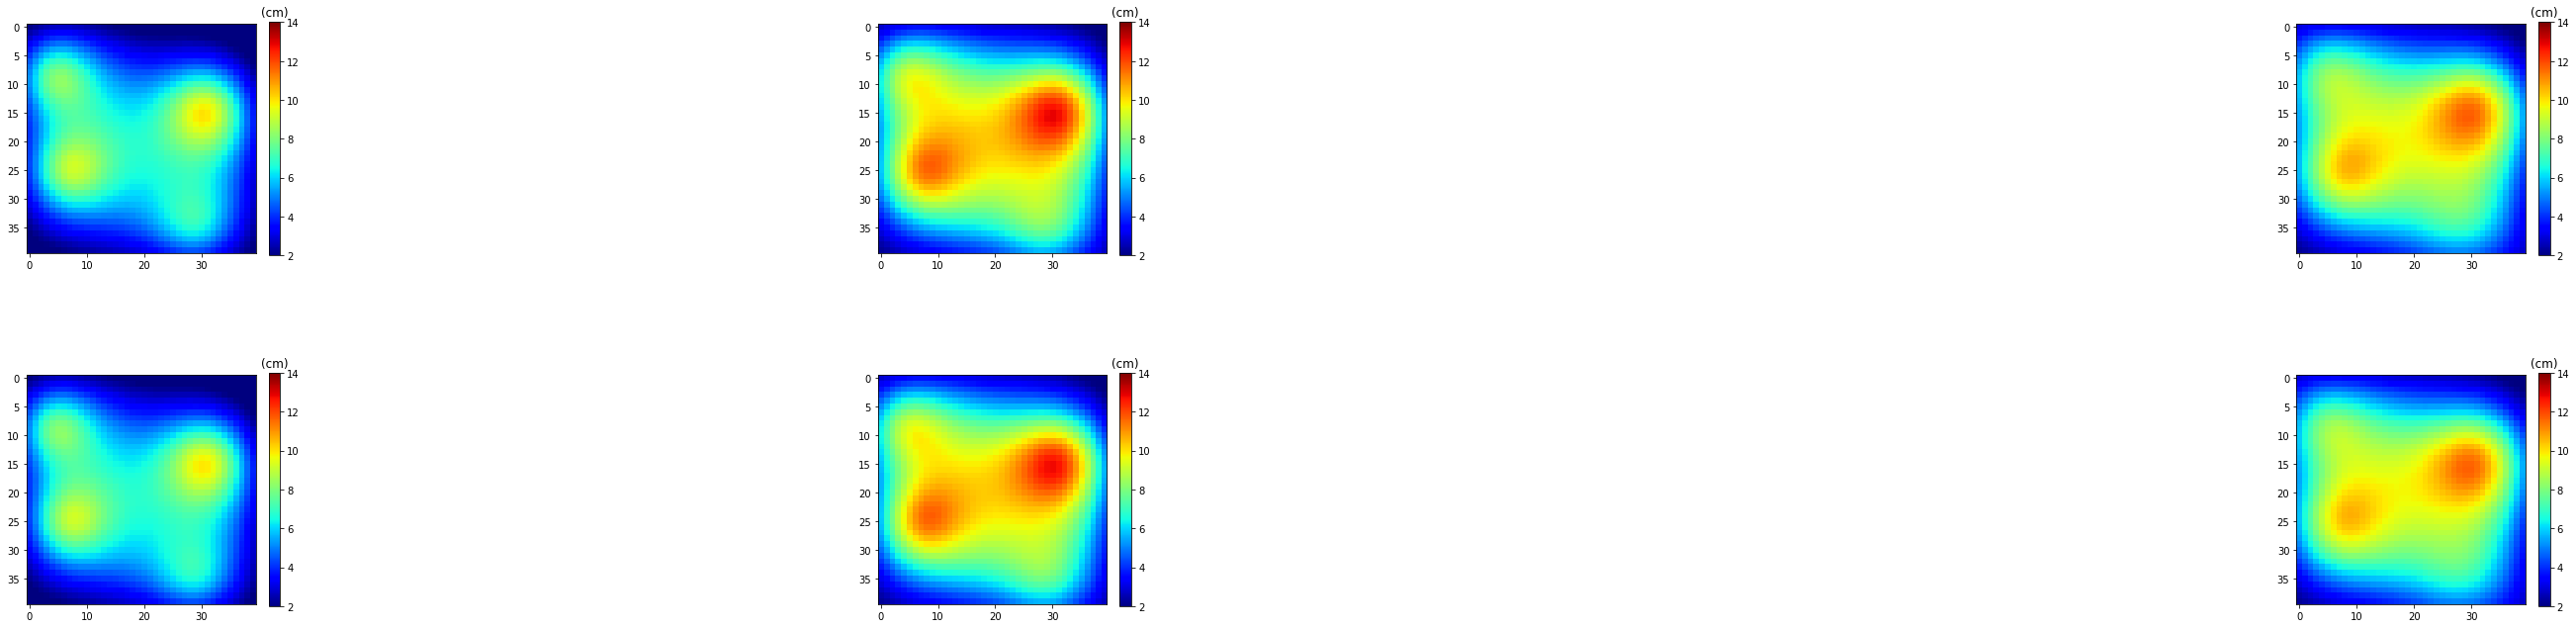

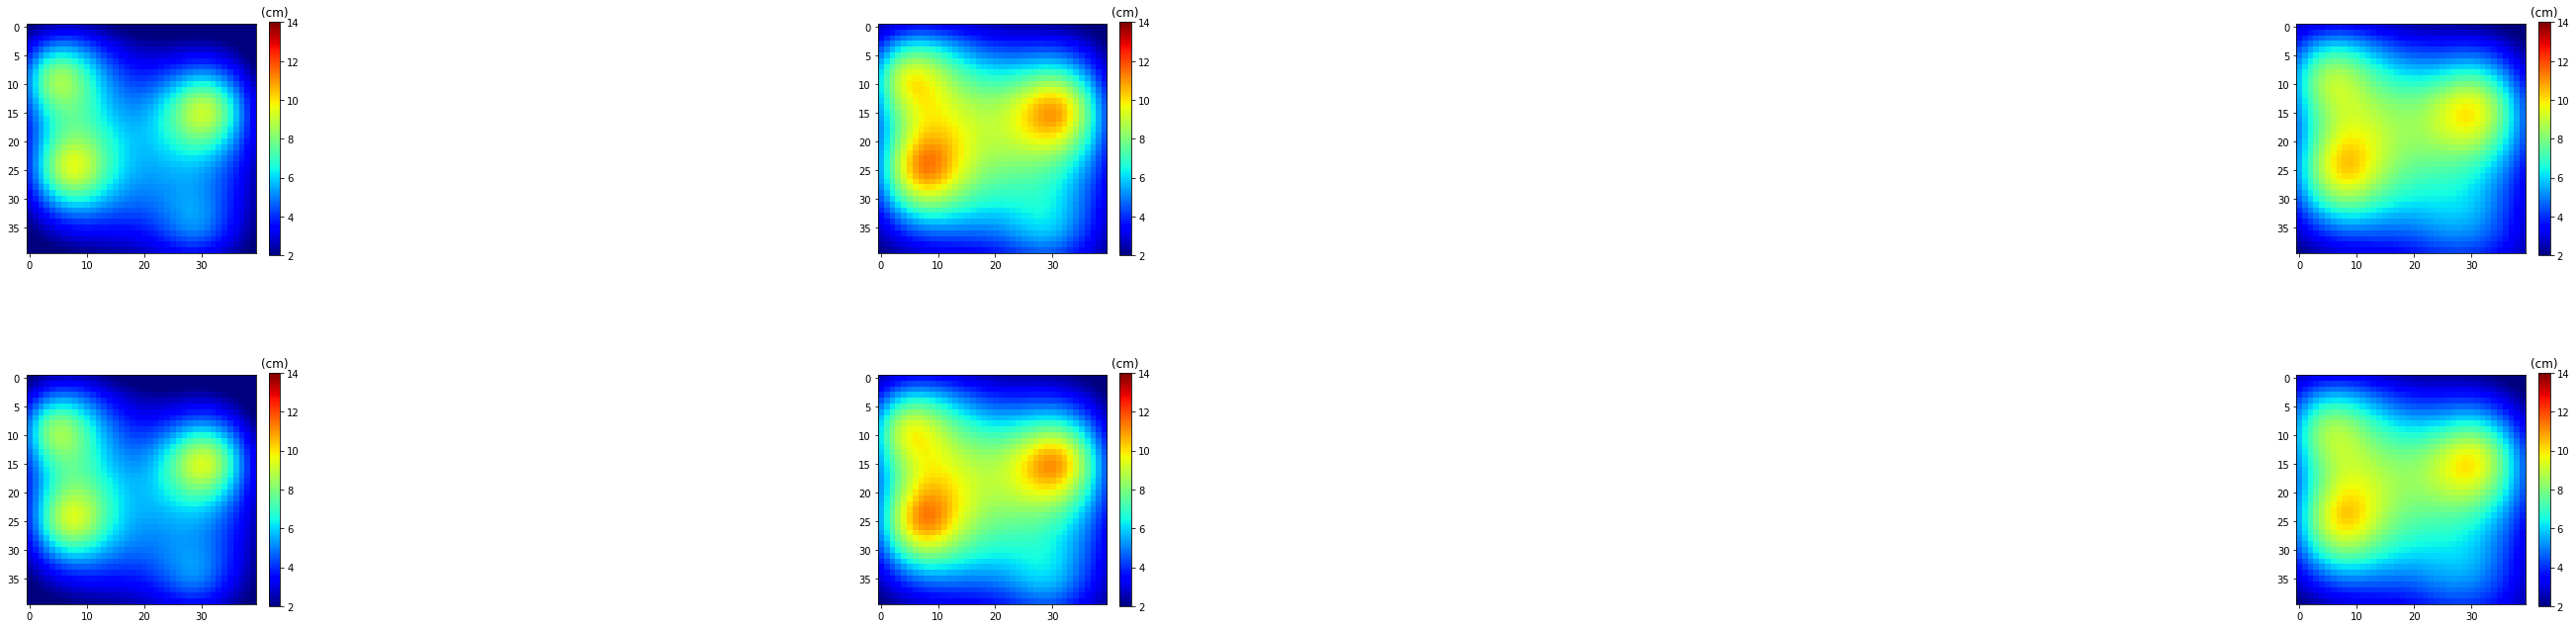

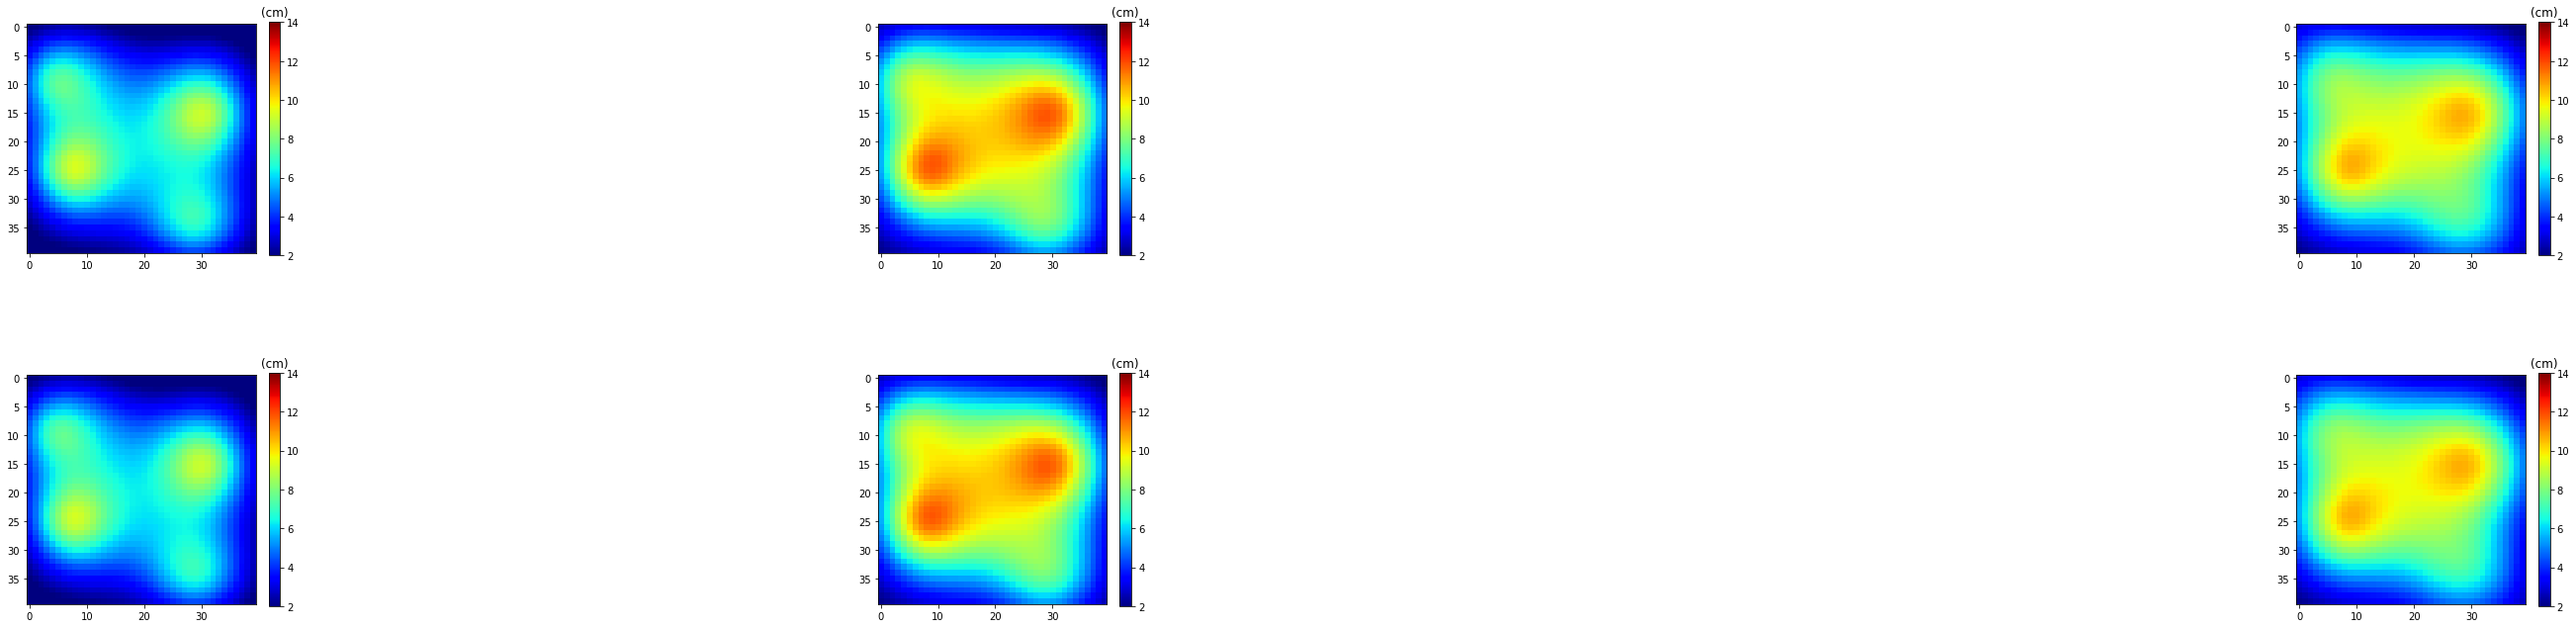

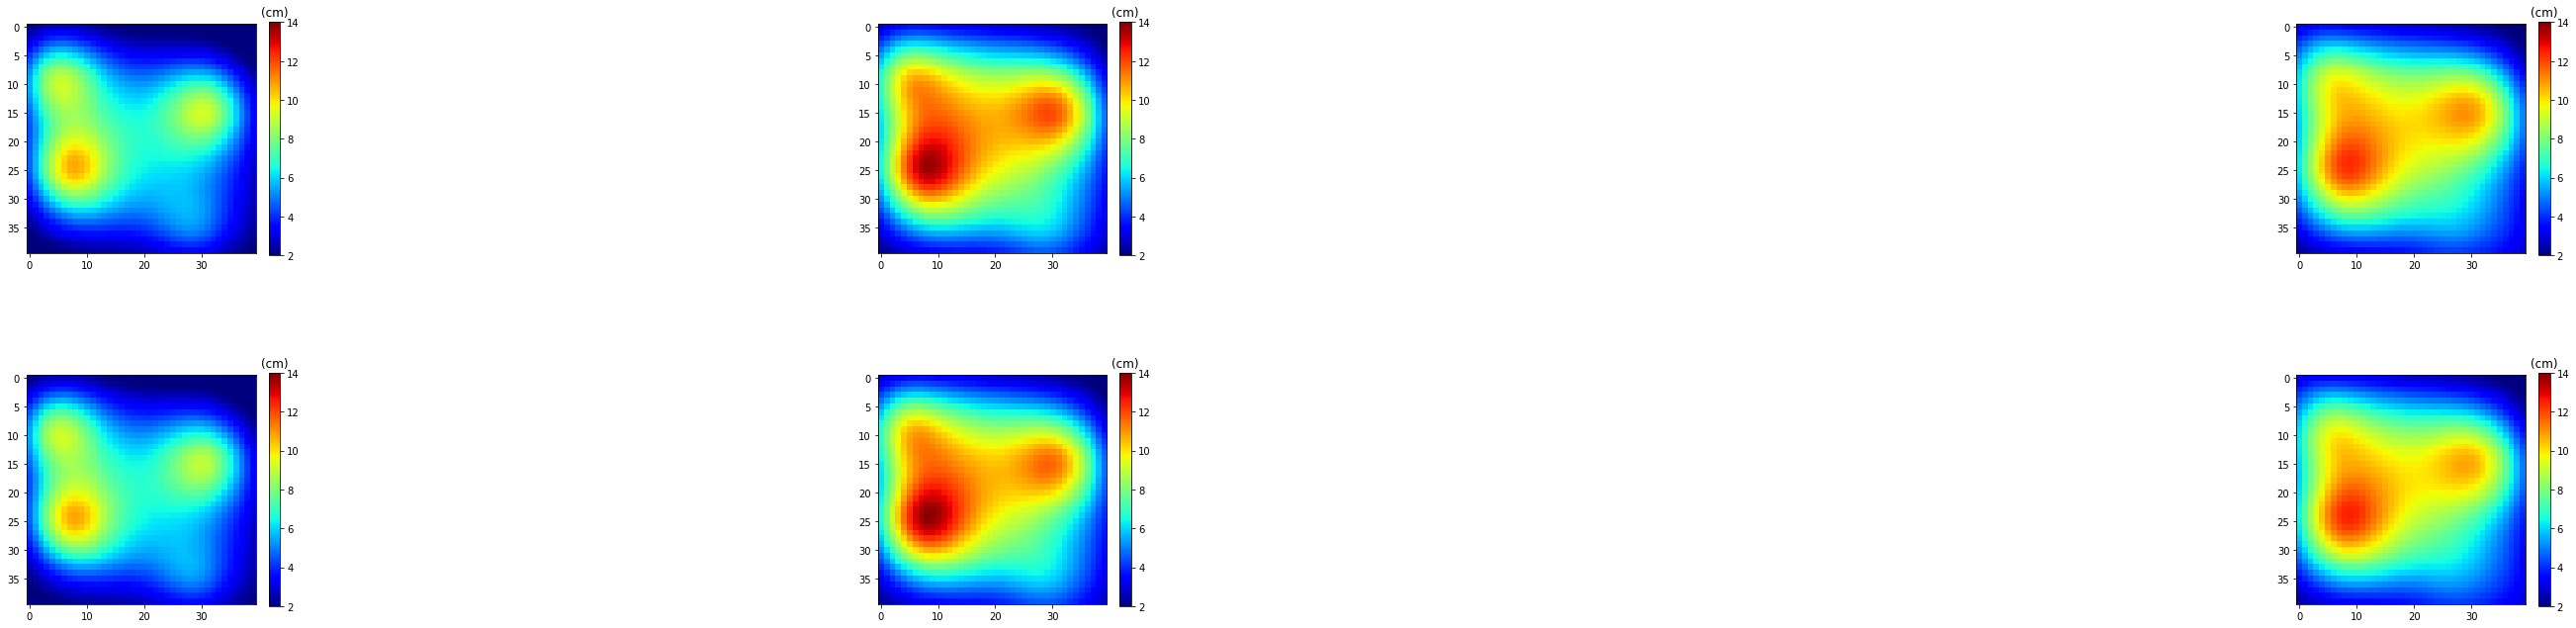

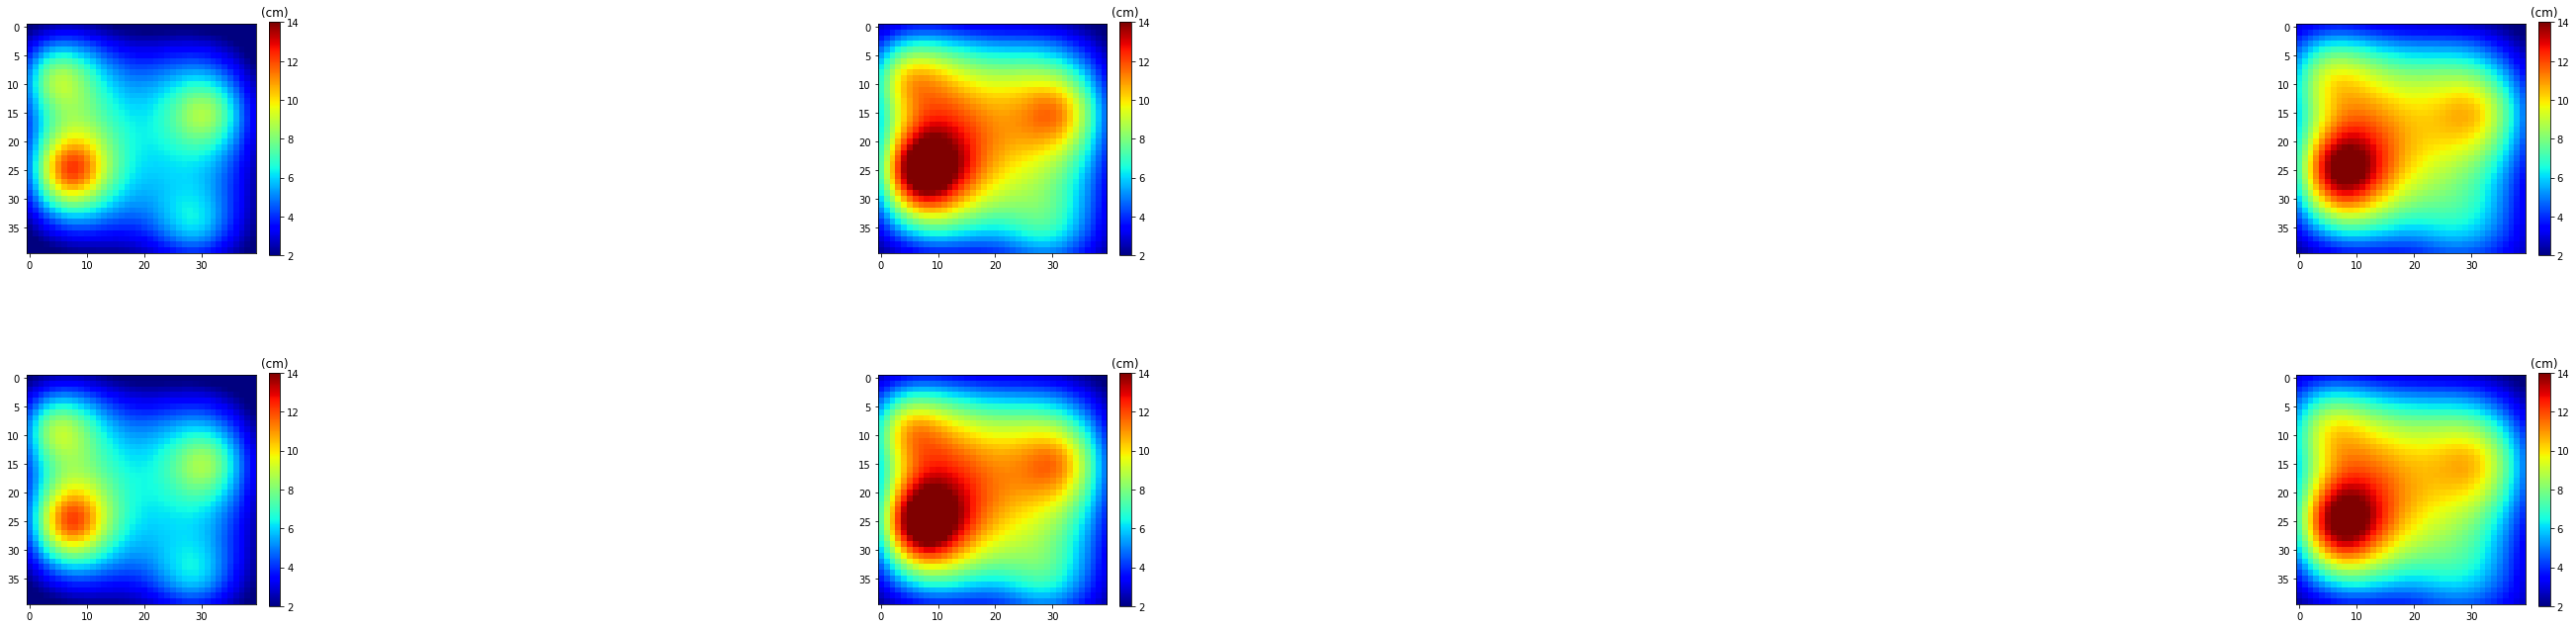

In [35]:
ind_case = [1, 2, 3, 4, 5, 6, 7, 8]
ind_z = 0
for k in ind_case:
    plt.figure(figsize=(40,10))
    for i_tstep in [1, 4, 9]:
        plt.subplot(2, depth, i_tstep+1)
       
        plt.imshow(d_pred[k, i_tstep, 0, :, ::-1] * 100, vmin = 2, vmax = 14)
        clb = plt.colorbar(fraction = 0.046)
        clb.ax.set_title('(cm)')
        plt.subplot(2, depth, i_tstep+1+depth)
        plt.imshow(d_true[k, i_tstep, 0, :, ::-1] * 100, vmin = 2, vmax = 14)
        clb = plt.colorbar(fraction = 0.046)
        clb.ax.set_title('(cm)')
        
        
        plt.tight_layout()
plt.show()

In [36]:
d_pred.shape

(500, 10, 12, 40, 40)

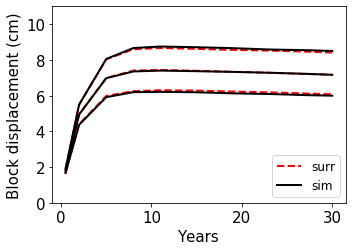

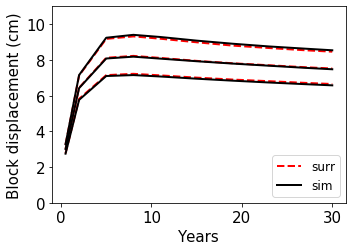

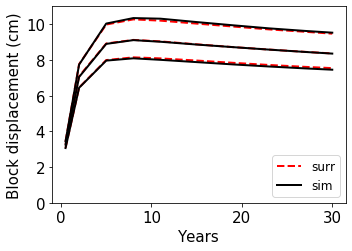

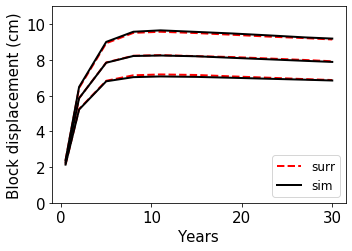

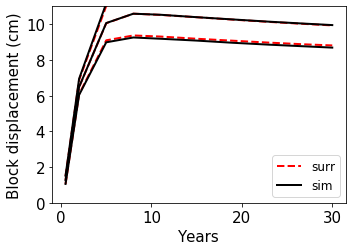

In [42]:

tsteps = [0.5, 2.0 , 5.0, 8.0, 11., 15., 19., 23., 27., 30.]


obs_loc_x = [9, 10, 35, 31, 20]
obs_loc_y = [7, 30, 15, 32, 20]


for i in range(len(obs_loc_x)):
    y, x = obs_loc_y[i], obs_loc_x[i]
    area_pred = d_pred[:, :, -1, y, x] * 100
    area_true = d_true[:, :, -1, y, x] * 100
    
    plt.figure(figsize = (5, 3.6))

    plt.plot(tsteps, np.percentile(area_pred, q = 10, axis = 0), 'r--', label = 'surr', linewidth = 2)
    plt.plot(tsteps, np.percentile(area_pred, q = 50, axis = 0), 'r--', linewidth = 2)
    plt.plot(tsteps, np.percentile(area_pred, q = 90, axis = 0), 'r--', linewidth = 2)

    plt.plot(tsteps, np.percentile(area_true, q = 10, axis = 0), color = 'k', label = 'sim', linewidth = 2)
    plt.plot(tsteps, np.percentile(area_true, q = 50, axis = 0), color = 'k', linewidth = 2)
    plt.plot(tsteps, np.percentile(area_true, q = 90, axis = 0), color = 'k', linewidth = 2)

    plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Years', fontsize=15)
    plt.ylim([0, 11])
    plt.ylabel('Block displacement (cm)', fontsize = 15)
    plt.legend( prop={'size': 12, }, loc = 'lower right')
    plt.tight_layout()
    plt.savefig('./saved_plots/test_disp_well%d.png'%(i + 1))

In [38]:
d_pred.shape

(500, 10, 12, 40, 40)

In [39]:
##Compute error   ground_disp_t = ground_disp_t / (ground_disp_t_std + 1e-6)
d_error = np.mean(np.abs(d_pred - d_true)/ d_true, axis = (0,2,3,4))

In [40]:
d_error

array([0.01122536, 0.008839  , 0.01111637, 0.01250693, 0.01311864,
       0.01327736, 0.01322159, 0.01318126, 0.01314687, 0.01313024])

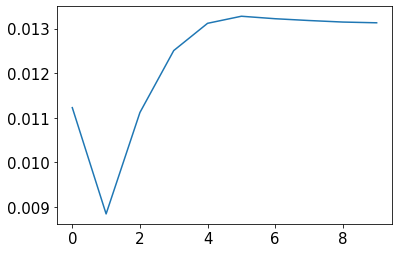

In [41]:
plt.figure()
plt.plot(d_error)
plt.show()

In [36]:
np.mean(d_error)

0.012276362555262404

In [37]:
d_pred.shape

(500, 10, 12, 40, 40)

In [38]:
d_pred_final = np.mean(d_pred, axis = 2)
d_true_final = np.mean(d_true, axis = 2)

In [39]:
d_pred_final.shape

(500, 10, 40, 40)

In [ ]:
hw = h5py.File('disp_pred_true_500test.h5', 'w')
hw.create_dataset('d_pred_final', data = d_pred_final)
hw.create_dataset('d_true_final', data = d_true_final)
hw.create_dataset('d_pred', data = d_pred)
hw.create_dataset('d_true', data = d_true)
hw.close()

In [39]:
d_true.shape

(500, 10, 12, 40, 40)

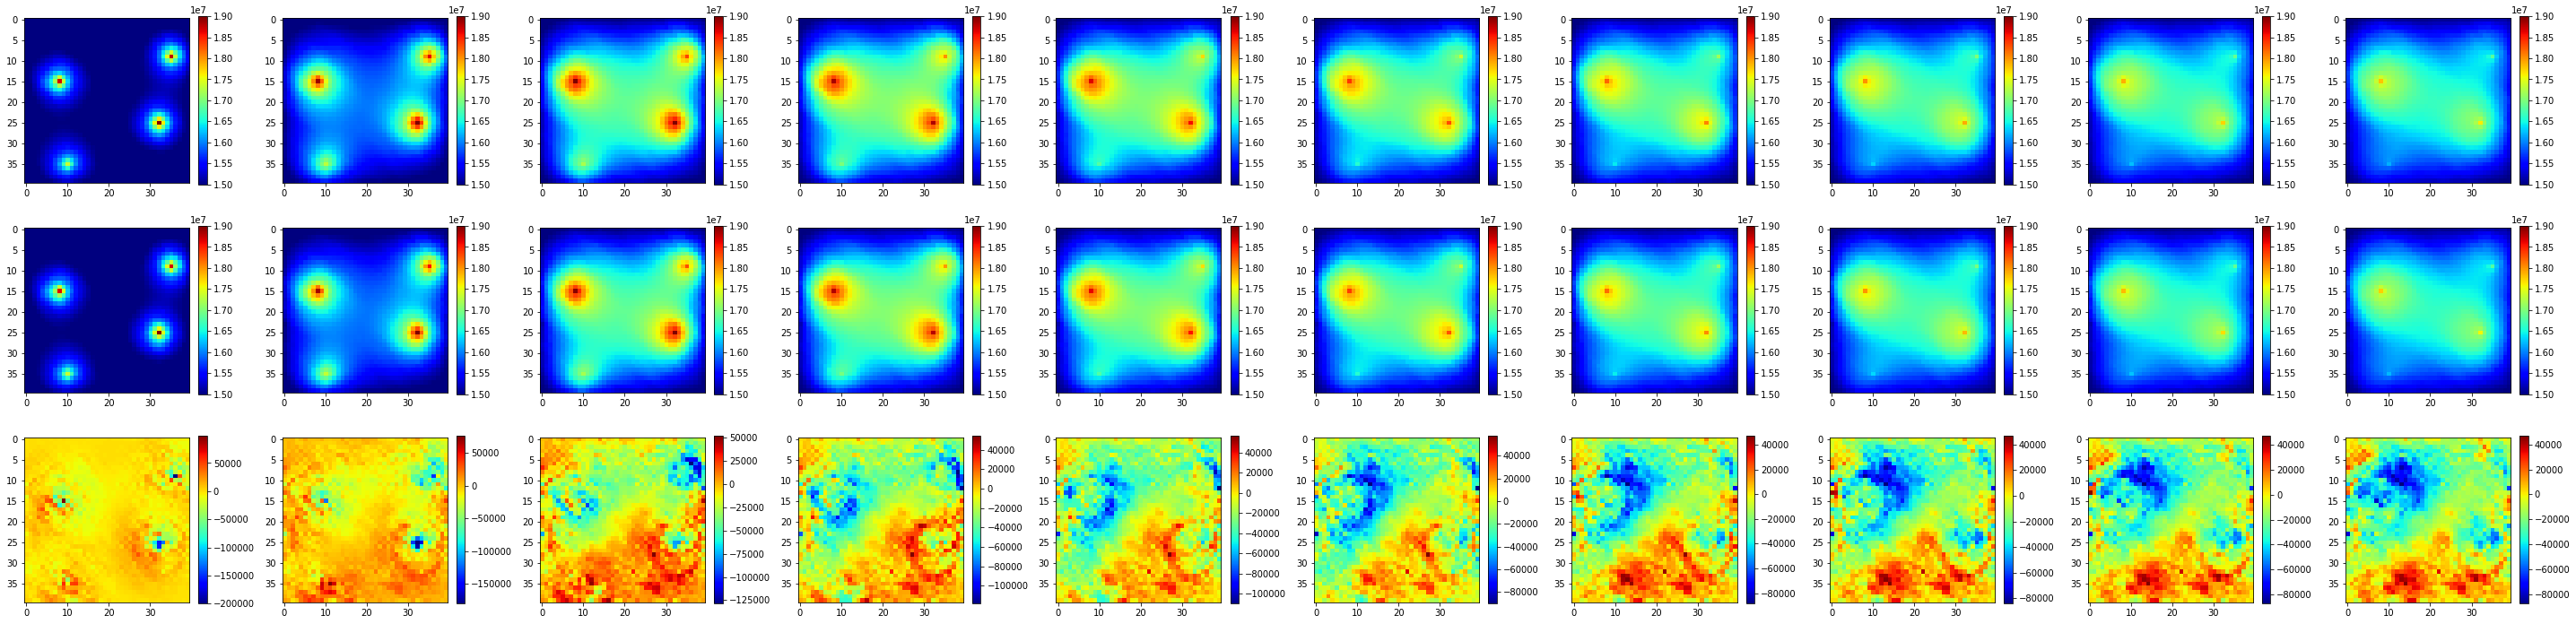

In [44]:
ind_case = [200]
ind_z = 0
for k in ind_case:
    plt.figure(figsize=(40,10))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(p_pred[k, i_tstep, 0, :, :], vmin = 1.5e7, vmax = 1.9e7)
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(p_true[k, i_tstep, 0, :, :], vmin = 1.5e7, vmax = 1.9e7)
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(p_true[k, i_tstep, 0, :, :] - p_pred[k, i_tstep, 0, :, :])

        plt.colorbar(fraction=0.046)
        #plt.clim([-0.2, 0.2])
        plt.tight_layout()
plt.show()

In [41]:
nx, ny, nz = 40, 40, 12
from mpl_toolkits.mplot3d import Axes3D 
voxels = np.ones((nx,ny,nz))
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

In [49]:
max_ = np.max(p_pred)
min_ = np.min(p_pred)

In [ ]:
i_tstep = 1
for k in [1, 10, 100, 200, 300]:
    fig = plt.figure(figsize=(6, 12))
    ax = fig.add_subplot(2, 1, 1, projection='3d')
    data = p_pred[k, i_tstep, ::-1, :, :].transpose((2,1,0))
    data = (data[:, :, ::-1] - min_) / (max_ - min_)
    colors = plt.cm.jet(data)
    ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
    axisEqual3D(ax)
    ax.voxels(voxels, facecolors=colors, edgecolor=None)
    plt.title("pressure prediction %d" % (k+1))
    ax = fig.add_subplot(2, 1, 2, projection='3d')
    data = p_true[k, i_tstep, ::-1, :, :].transpose((2,1,0))
    data = (data[:, :, ::-1] - min_) / (max_ - min_)
    colors = plt.cm.jet(data)
    ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
    axisEqual3D(ax)
    ax.voxels(voxels, facecolors=colors, edgecolor=None)
    plt.title("pressure true %d" % (k+1))
    plt.show()

In [ ]:
i_tstep = 3
for k in [1, 10, 100, 200, 300]:
    fig = plt.figure(figsize=(6, 12))
    ax = fig.add_subplot(2, 1, 1, projection='3d')
    data = p_pred[k, i_tstep, ::-1, :, :].transpose((2,1,0))
    data = (data[:, :, ::-1] - min_) /  (max_ - min_)
    colors = plt.cm.jet(data)
    ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
    axisEqual3D(ax)
    ax.voxels(voxels, facecolors=colors, edgecolor=None)
    plt.title("pressure prediction %d" % (k+1))
    ax = fig.add_subplot(2, 1, 2, projection='3d')
    data = p_true[k, i_tstep, ::-1, :, :].transpose((2,1,0))
    data = (data[:, :, ::-1] - min_) /  (max_ - min_)
    colors = plt.cm.jet(data)
    ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
    axisEqual3D(ax)
    ax.voxels(voxels, facecolors=colors, edgecolor=None)
    plt.title("pressure true %d" % (k+1))
    plt.show()

In [ ]:
i_tstep = -1
for k in [1, 10, 100, 200, 300]:
    fig = plt.figure(figsize=(6, 12))
    ax = fig.add_subplot(2, 1, 1, projection='3d')
    data = p_pred[k, i_tstep, ::-1, :, :].transpose((2,1,0))
    data = (data[:, :, ::-1] - min_) /  (max_ - min_)
    colors = plt.cm.jet(data)
    ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
    axisEqual3D(ax)
    ax.voxels(voxels, facecolors=colors, edgecolor=None)
    plt.title("pressure prediction %d" % (k+1))
    ax = fig.add_subplot(2, 1, 2, projection='3d')
    data = p_true[k, i_tstep, ::-1, :, :].transpose((2,1,0))
    data = (data[:, :, ::-1] - min_) /  (max_ - min_)
    colors = plt.cm.jet(data)
    ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
    axisEqual3D(ax)
    ax.voxels(voxels, facecolors=colors, edgecolor=None)
    plt.title("pressure true %d" % (k+1))
    plt.show()

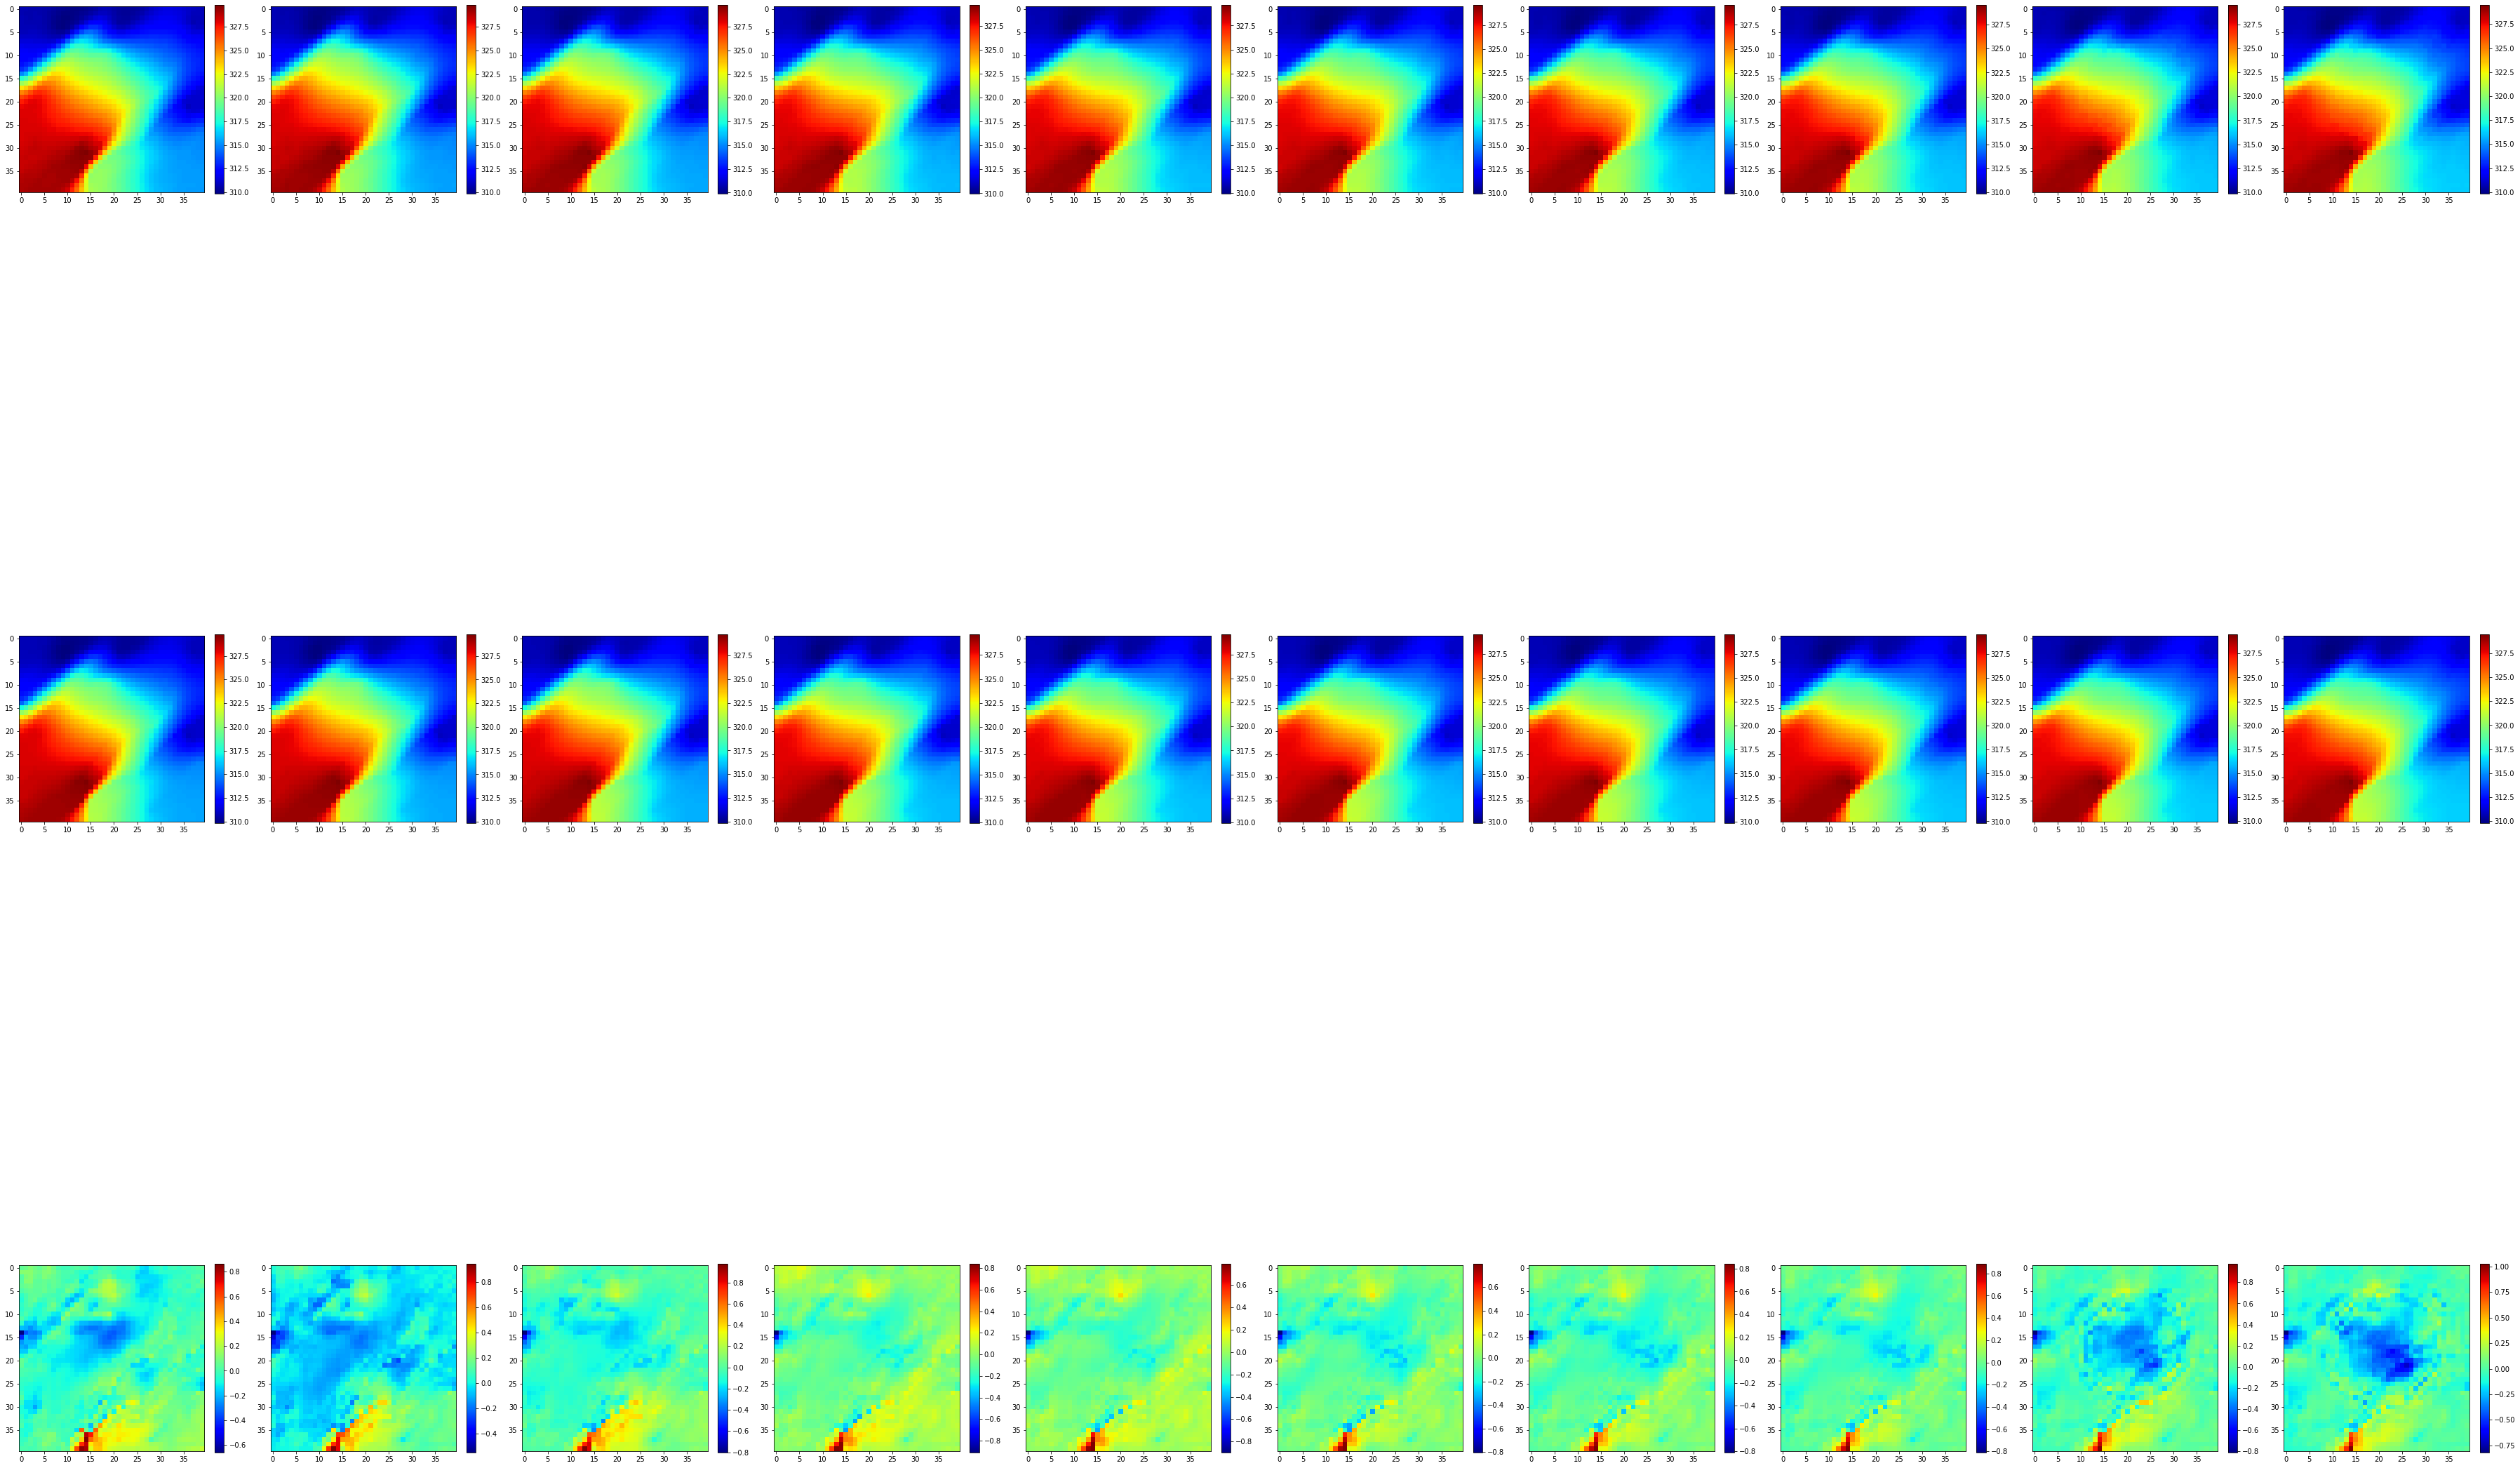

In [28]:
ind_z = 2
for k in ind_case:
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(p_pred[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(p_true[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(p_true[k, ind_z, :, :, i_tstep] - p_pred[k, ind_z, :, :, i_tstep])

        plt.colorbar(fraction=0.046)
        plt.tight_layout()
plt.show()

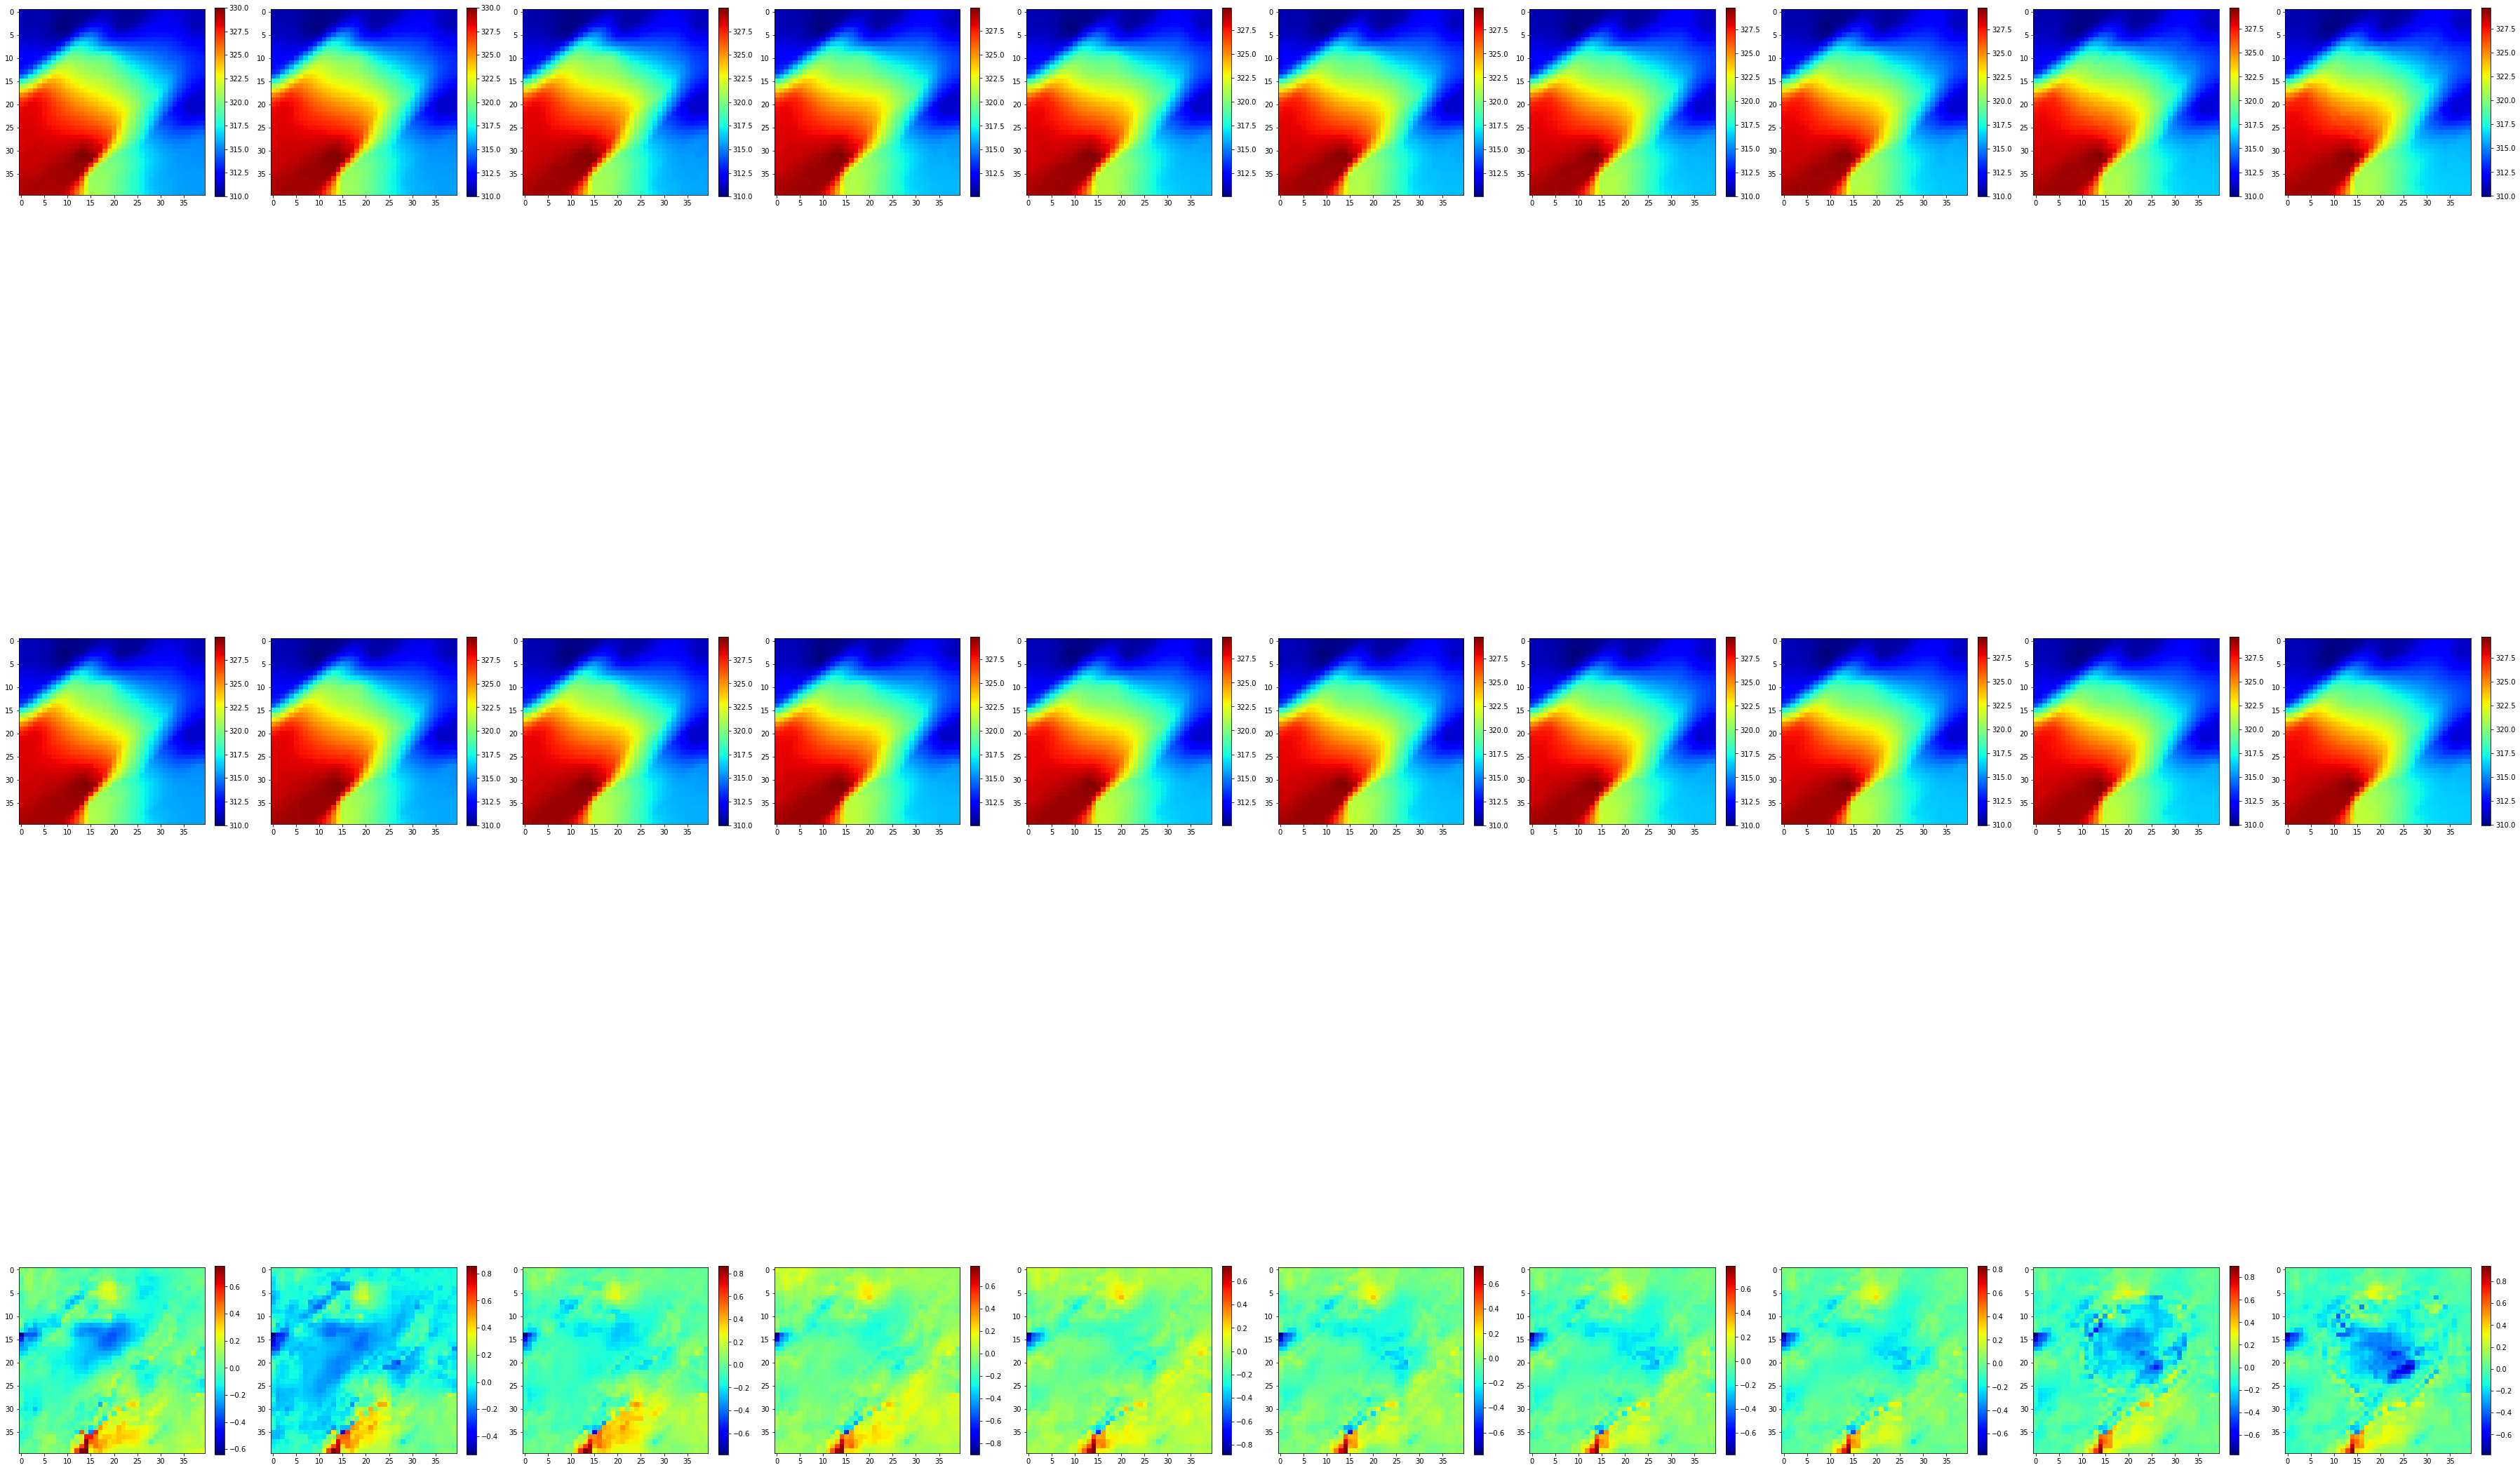

In [29]:
ind_z = 3
for k in ind_case:
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(p_pred[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(p_true[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(p_true[k, ind_z, :, :, i_tstep] - p_pred[k, ind_z, :, :, i_tstep])

        plt.colorbar(fraction=0.046)
        plt.tight_layout()
plt.show()